# Проект - Промышленность 
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

#  Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных 

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

### Дополнительная информация
По информации от заказчика температура плавления нашего металла 1500 градусов, все что ниже аномалии

# Цель проекта
Построить модель машинного обучения, которая сможет искусственно воспроизводить процесс создания сплава, определяя его конечную температуру. Таким образом можно будет проводить численные эксперименты по оптимизации технологического процесса, - (сокращение или увеличения цикла циклов до достижения сплавом определенной консистенции, оптимизация времени нагрева) - что позволит сократить расходы материалов и электроэнергии.

# План выполнения 
* Исследовательский анализ данных
    * Сделаем описание каждого из датасетов
    * Визуализации и оценки распределений
    * Поиск аномальных значений, выбросов
* Построение основного датасета для обучения моделей
    * Сбор данных из всех представленных датасетов в один
    * Исключение аномалий
    * Добавление новых признаков (физических)
* Построение пайплайнов для обучения ML моделей 
    * Будем тестировать три ML модели: (Линейная регрессия, модель случайного леса и модель градиентного бустинга)
    * Возможно добавление новых признаков в основной датасет или исключение неинформативных. Новые признаки, если и будут, то скорее всего синтетические 
* Отбор лучшей модели
    * Оценка моделей по метрике MAE
    * Сравнение с константной моделью
* Подготовка отчета

# Используемые библиотеки

In [1]:
!pip install scikit-optimize

In [2]:
!pip install lightgbm

In [3]:
!pip install catboost

In [4]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib
from functools import reduce
from collections import Counter

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

In [5]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_objective
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных 

In [6]:
if os.path.exists('final_steel'):
    path_to_data = 'final_steel'
else:
    path_to_data = '/datasets/final_steel/'

In [7]:
file_names = [
    'data_arc',
    'data_bulk',
    'data_bulk_time',
    'data_gas',
    'data_temp',
    'data_wire',
    'data_wire_time'
]

Так можно создать переменные с именами из `file_names` и положить в них наши данные

PS: Уж, очень не хотелось копировать столько строк

In [8]:
for file in file_names:
    globals()[file] = pd.read_csv(os.path.abspath(os.path.join(path_to_data, f'{file}.csv')))

# EDA

## Изучение таблиц


В этом разделе будем только изучать начальные данные - смотреть на их типы, пропуски, примечать аномалии. Исправлять, убирать все странные значения будем уже после.

### Данные о температуре стали `data_temp` (target)

In [9]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [10]:
data_temp.isna().sum(axis=0)

key                0
Время замера       0
Температура     2901
dtype: int64

Есть пропуски, но пока их просто примечаем. Отсеивать будем только если будет пропущена конечная температура

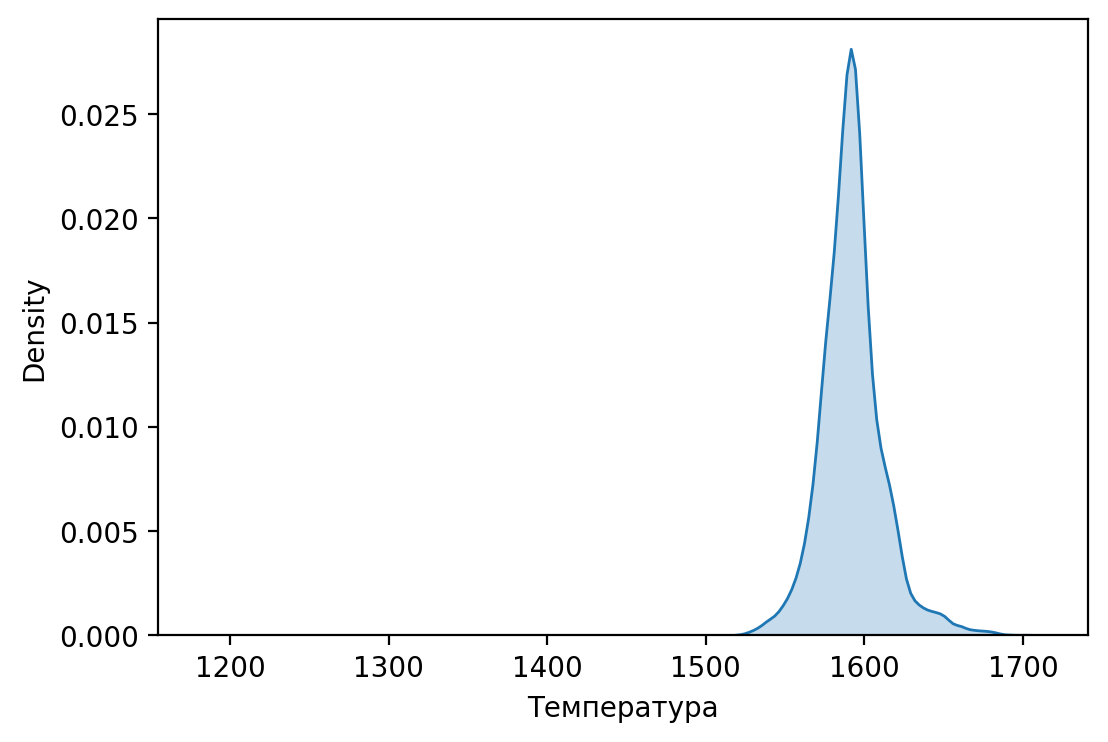

In [11]:
plt.figure(figsize=(6, 4))
sns.kdeplot(data=data_temp, x='Температура', fill=True);

Тут нам по условию сказано, что температура сплава не может быть ниже 1500, так что выбросы слева мы будет просто удалять. 

Можно посмотреть, что за аномалии у нас в датасете

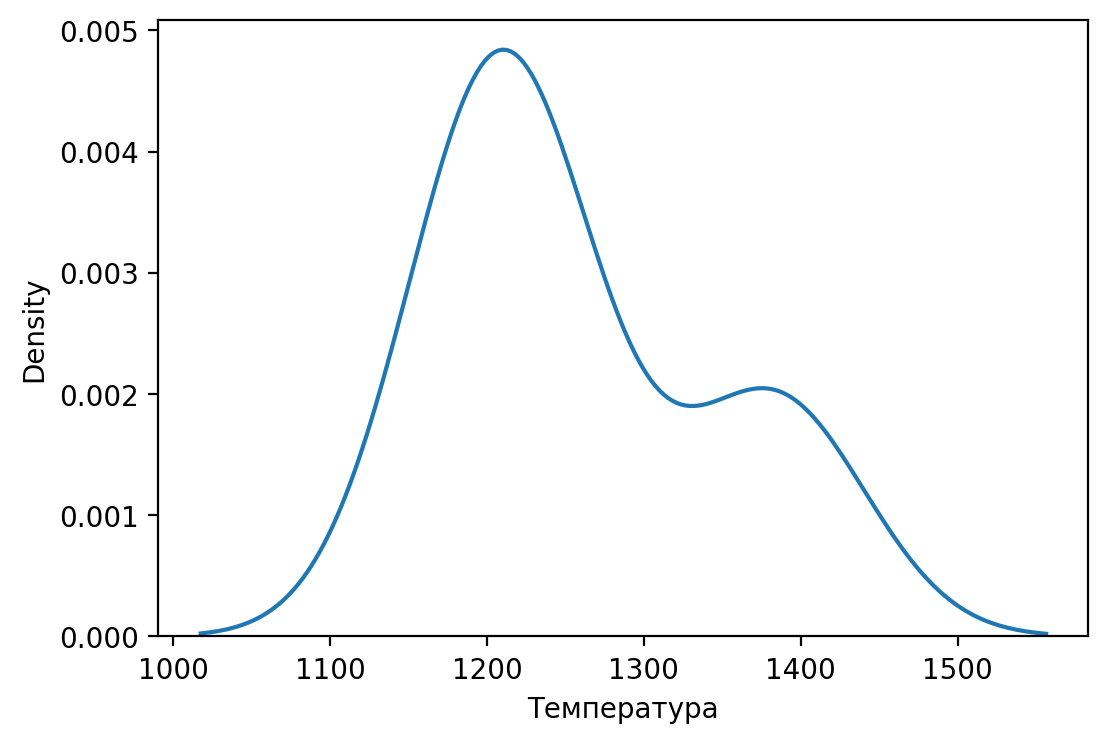

In [12]:
tmp = data_temp.loc[(data_temp['Температура'] < 1500)]
plt.figure(figsize=(6,4))
sns.kdeplot(data=tmp, x='Температура');

In [13]:
tmp

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


Хоть распределение и интересное, но это аномалии, их всего 7 штук, поэтому в будущем мы их уберем

In [14]:
KEY_TO_DROP = list(tmp['key'].values)

Еще можно посмотреть количество измерений температуры для уникального ключа

In [15]:
tmp = data_temp.groupby('key').agg('count')

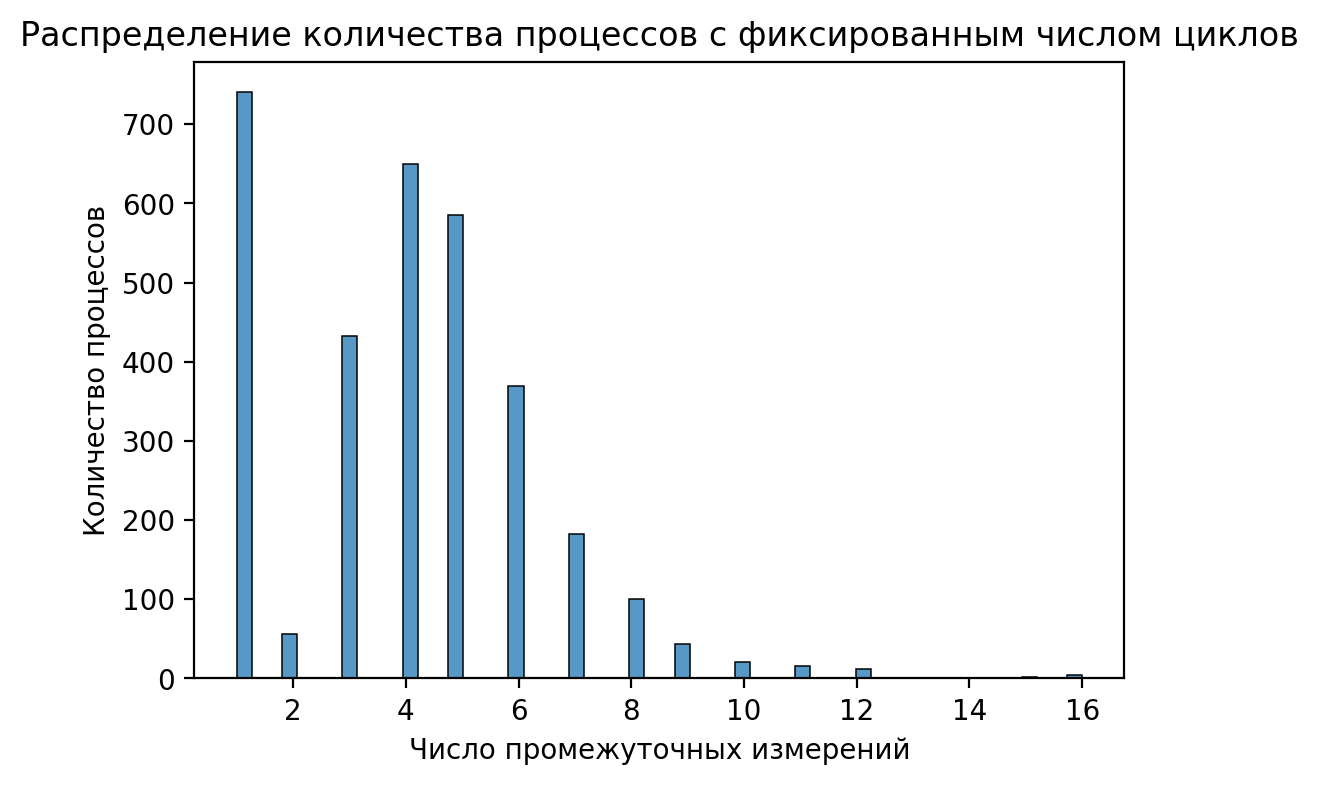

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(data=tmp, x=tmp['Температура'])
ax.set(
    title='Распределение количества процессов с фиксированным числом циклов',
    ylabel='Количество процессов',
    xlabel='Число промежуточных измерений'
);

In [17]:
tmp.loc[tmp['Температура'] == 1].sum()

Время замера    3642
Температура      741
dtype: int64

Получается, как минимум 741 значение "под особым подозрением", но для нас важно, чтобы была известна финальная температура

In [18]:
data_temp.head(1)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0


Посмотрим какие измерения стоит рассматривать. Для этого сделаем сводную таблицу, в которой выделим начальную температуру сплава и конечную. Тут можно попробовать временно проставить в пропуски значения, например -1. Тогда если в последнем цикле температура не измерилась, то у нас вылезет -1. Промежуточное значение также не сможет попасть по ошибке, так как -1 проставится для всех пропущенных значений температуры

In [19]:
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format=TIME_FORMAT)

In [20]:
pt_temp = data_temp.fillna(-1).pivot_table(values='Температура',
                                           index='key', 
                                           aggfunc=['first', 'last']
                                          )
pt_temp.columns = ['start', 'finish']

In [21]:
sum(pt_temp['finish'] == -1)

739

Получается 739 ключей все-таки придется удалить. Сейчас поместим эти значение в отдельную переменную, возможно ключи еще добавятся из других датасетов. Удалим из общей таблицы

In [22]:
KEY_TO_DROP.extend(list(pt_temp.loc[pt_temp['finish'] == -1].index))

In [23]:
KEY_TO_DROP[-10:]

[3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241]

Любопытно, что номера измерений из последовательно и в конце. Может быть, это технический сбой не столько в системе, сколько при обработке/пересылке

### Данные об электродах `data_arc`

In [24]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


На первый взгляд все здорово - пропусков нет)

In [25]:
data_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Есть два временных столбца - нужно будет поправить тип данных и проверить, что все записи идут по порядку и конец нагрева всегда позже начала

In [26]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Тут есть отрицательное значение по реактивной мощности. Про него тоже сказано в условии - это аномалия. Следовательно, тоже просто удалим ее

In [27]:
(data_arc['Реактивная мощность'] < 0).sum()

1

Она всего одна

In [28]:
data_arc.loc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [29]:
KEY_TO_DROP.append(2116)

Построим распределения мощностей

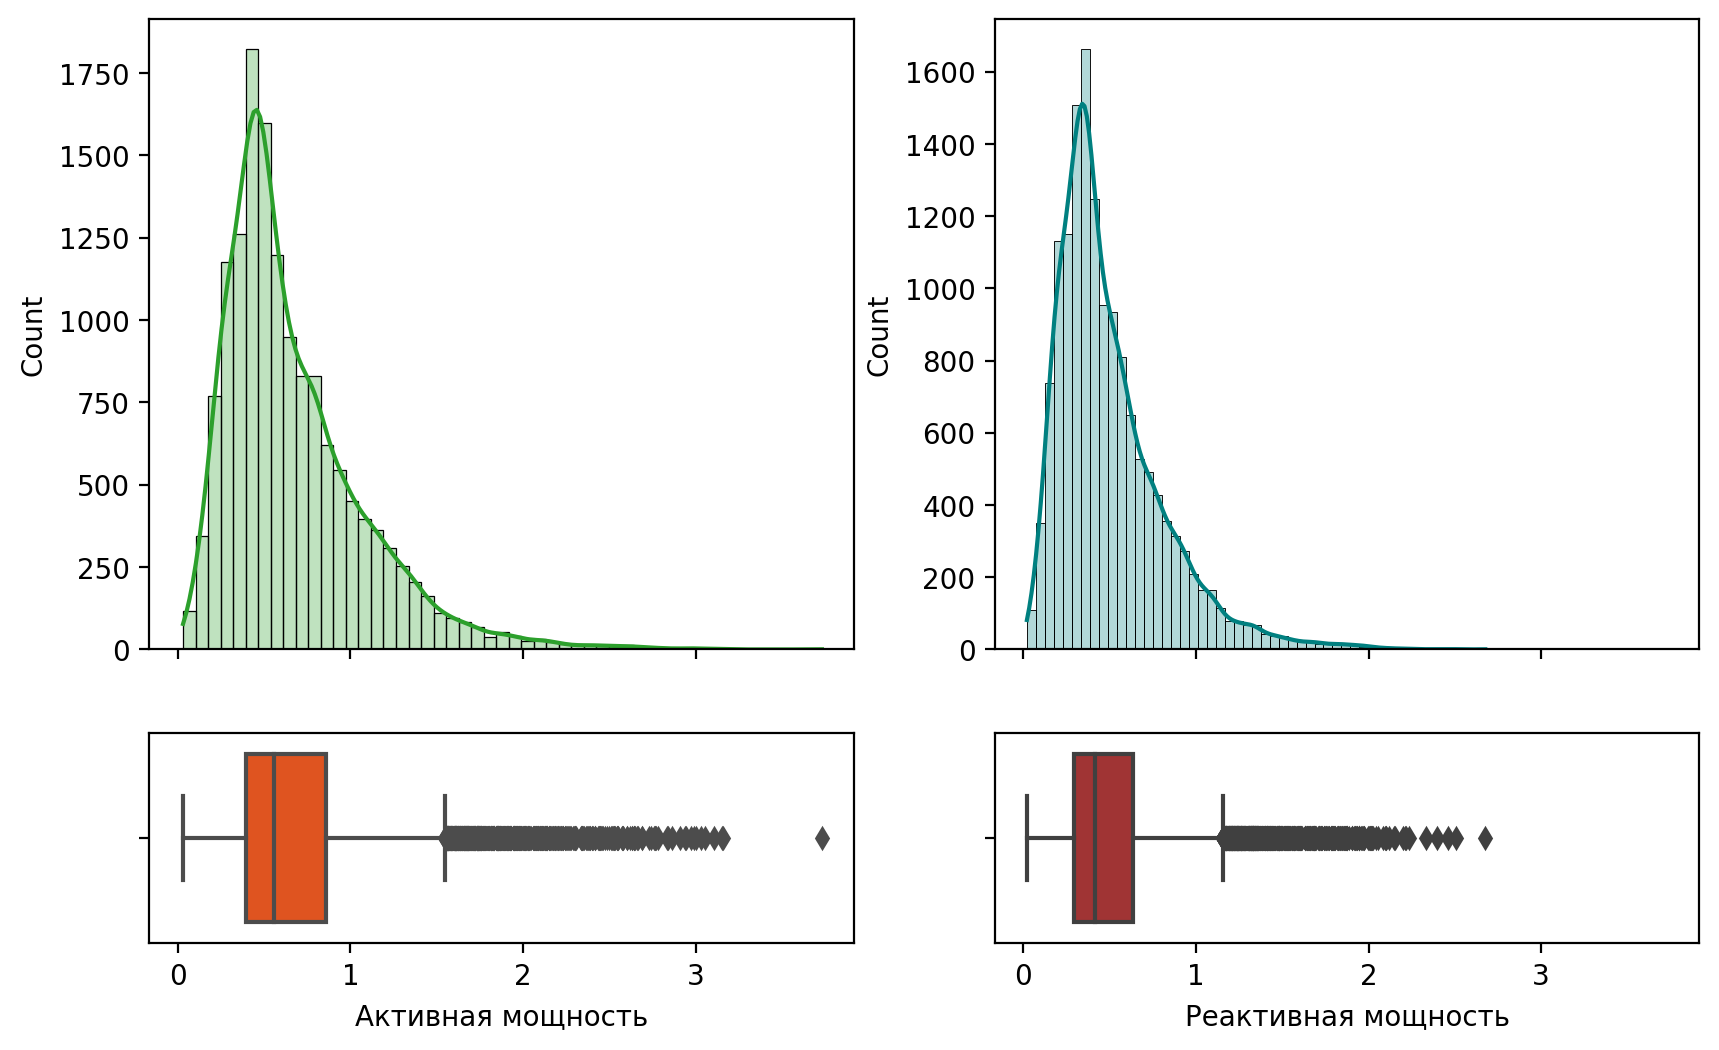

In [30]:
fig, ax = plt.subplots(2, 2, 
                       figsize=(10, 6), 
                       sharex=True,
                       gridspec_kw={"height_ratios":(3, 1)}
                      )
sns.histplot(ax=ax[0, 0], data=data_arc['Активная мощность'], bins=51, color='tab:green', alpha=0.3, kde=True)
sns.boxplot(ax=ax[1, 0], x=data_arc['Активная мощность'], color='orangered')


pos_react_index = data_arc['Реактивная мощность'] >= 0
sns.histplot(ax=ax[0, 1], data=data_arc.loc[pos_react_index, 'Реактивная мощность'], bins=51, color='teal', alpha=0.3, kde=True)
sns.boxplot(ax=ax[1, 1], x=data_arc.loc[pos_react_index, 'Реактивная мощность'], color='firebrick');

Распределения похожи на логнормальное, можно для модели попробовать взять логарифм, тогда будет нормальное распределение, может это даст какой-нибудь выигрыш

### Данные о подаче сыпучих материалов `data_bulk`, `data_bulk_time`

#### Материалы

In [31]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Так, здесь куча пропусков, и, мне кажется, что это вполне адекватно, если предположить, что сплав из разных компонентов состоит

In [32]:
tmp = data_bulk.drop('key', 1)

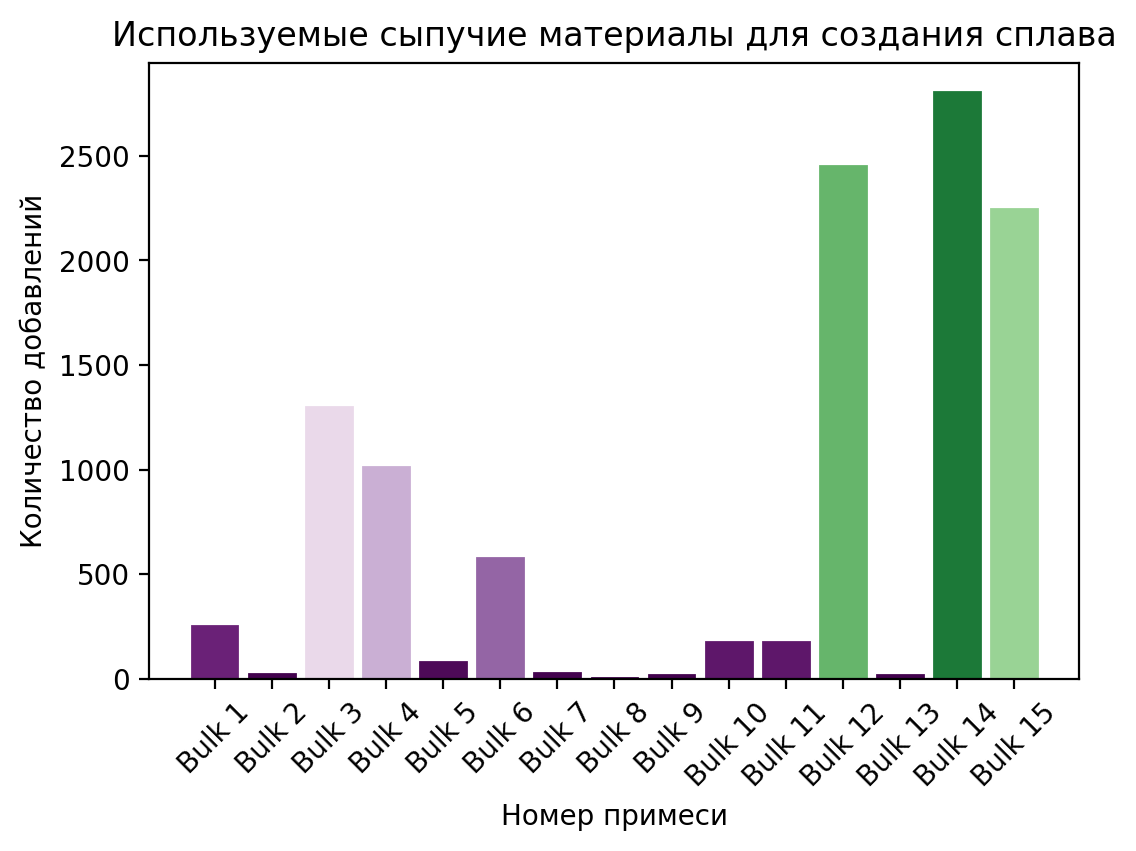

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
bars = ax.bar(tmp.columns, tmp.count())
for val, bar in zip(tmp.count(), bars):
    norm = matplotlib.colors.Normalize(0, 3129)
    bar.set_color(plt.cm.PRGn(norm(val)))
ax.tick_params(axis='x', rotation=45)
ax.set(
    title='Используемые сыпучие материалы для создания сплава',
    xlabel='Номер примеси',
    ylabel='Количество добавлений'
);

Получается, что материалы далеко не одинаковое число раз добавляют. По сути используется только половина представленных материалов. После составления итоговой таблицы можно будет отдельно посмотреть насколько отличаются сплавы с этими добавками. Но скорее всего это какие-то неудачные эксперименты. Чаще всего применяют добавки под номерами #12, #14 и #15

Теперь, я думаю, можно пропуски в этой табличке сразу заменить на нули, то есть "ничего не добавлялось"

In [34]:
data_bulk = data_bulk.fillna(0)

#### Временной датасет

In [35]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Здесь такое количество пропусков, вероятно, они на тех же самых местах

В конце мы будем составлять общую таблицу, поэтому, я думаю, что здесь можно соединить эти две таблички в одну

In [36]:
data_bulk_full = pd.merge(
    left=data_bulk,
    right=data_bulk_time, 
    how='inner',
    on='key',
    suffixes=('', ' time')
)

In [37]:
data_bulk_full.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,...,Bulk 6 time,Bulk 7 time,Bulk 8 time,Bulk 9 time,Bulk 10 time,Bulk 11 time,Bulk 12 time,Bulk 13 time,Bulk 14 time,Bulk 15 time
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20


### Данные о проволочных материалах `data_wire`, `data_wire_time`

### Проволоки

In [38]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Тут впринципе тоже самое, что и для предыдущего раздела, то есть много пропусков в данных из-за того, что не все элементы для конкретного сплава использовались

In [39]:
tmp = data_wire.drop('key', 1)

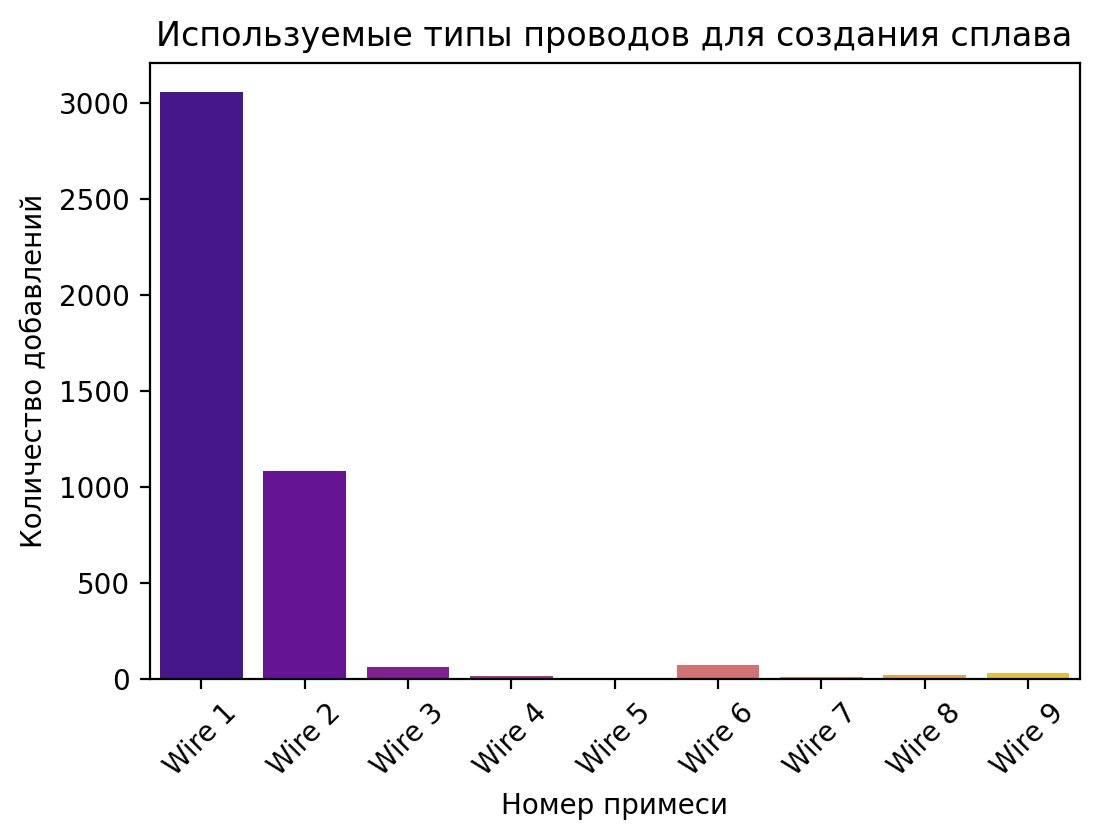

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(x=tmp.columns, y=tmp.count(), ci=None, palette='plasma')
ax.tick_params(axis='x', rotation=45)
ax.set(
    title='Используемые типы проводов для создания сплава',
    xlabel='Номер примеси',
    ylabel='Количество добавлений'
);

Тут тоже видно, что провода типа 1 и 2 намного чаще применяют. Вероятно, это определели эмпирически, а остальные - это снова неудачные попытки уменьшить температуру сплава. Вполне возможно, что провода типов 3 и 6 иногда давали увеличение температуры, так как их использовали чаще чем другие малоиспользуемые добавки.

По той же тактике сделаем пропуски нулями

In [41]:
data_wire = data_wire.fillna(0)

####  Временной датасет

In [42]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Число пропусков здесь также совпадает с данные о проволоках, поэтому сейчас мы соберем полную табличку для проволок, а потом, уже в полной таблице, проверим соответствие времен

In [43]:
data_wire_full = pd.merge(
    left=data_wire,
    right=data_wire_time, 
    how='inner',
    on='key',
    suffixes=('', ' time')
)

### Данные о продувке газом

In [44]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Получается, что использовался один вид инертного газа (возможно аргон, он самый дешевый, если верить гуглу)

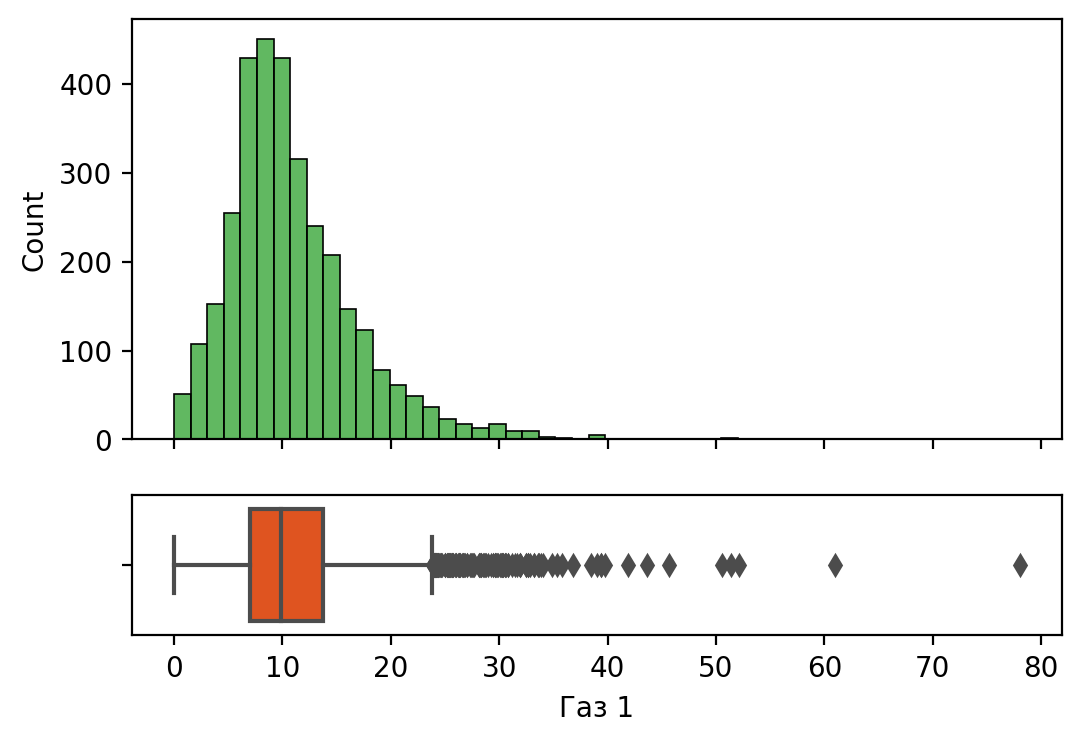

In [45]:
fig, ax = plt.subplots(2, 1, 
                       figsize=(6, 4), 
                       sharex=True,
                       gridspec_kw={"height_ratios":(3, 1)}
                      )
sns.histplot(ax=ax[0], data=data_gas['Газ 1'], bins=51, color='tab:green')
sns.boxplot(ax=ax[1], x=data_gas['Газ 1'], color='orangered');

Получается в большинстве случаев тратилось около 10 единиц (не увидел чего в описании), есть небольшое количество выбросов. Пока их не не трогаем, просто примечаем 

###  Сборка 
Первое знакомство с нашими данными мы сделали, теперь попробуем соединить наши данные в одну большую табличку. В итоговую таблицу я не стал включать временные отметки о добавлении материалов и проводов в сплав, так как пока не придумал как их использовать

In [46]:
datasets = [pt_temp.reset_index(), data_gas, data_arc, data_bulk, data_wire]

In [47]:
df_full = reduce(lambda left, right: pd.merge(left, right, on='key',  how='inner'), datasets)

Убираем все забракованные измерения 

In [48]:
df_full = df_full.query('key not in @KEY_TO_DROP')

In [49]:
df_full.tail()

,key,start,finish,Газ 1,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Bulk 1,Bulk 2,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
10931,2498,1591.0,1594.0,14.953657,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,0.0,0.0,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10932,2499,1569.0,1603.0,11.336151,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,0.0,0.0,...,227.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10933,2499,1569.0,1603.0,11.336151,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,0.0,0.0,...,227.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10934,2499,1569.0,1603.0,11.336151,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,0.0,0.0,...,227.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10935,2499,1569.0,1603.0,11.336151,2019-08-06 02:54:31,2019-08-06 02:55:42,0.312893,0.212472,0.0,0.0,...,227.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Сейчас можно переименовать столбцы, приведя их к более каноническому виду 

In [50]:
df_full.columns = df_full.columns.str.lower()
df_full.columns = df_full.columns.str.replace(' ', '_')

In [51]:
df_full = df_full.rename(
    columns={
        'start': 't0',
        'finish': 't',
        'газ_1': 'gas',
        'начало_нагрева_дугой': 'heating_start',
        'конец_нагрева_дугой': 'heating_finish',
        'активная_мощность': 'active_power', 
        'реактивная_мощность': 'reactive_power'
    }
)

In [52]:
df_full['heating_start'] = pd.to_datetime(df_full['heating_start'], format=TIME_FORMAT)
df_full['heating_finish'] = pd.to_datetime(df_full['heating_finish'], format=TIME_FORMAT)

In [53]:
df_full.head()

,key,t0,t,gas,heating_start,heating_finish,active_power,reactive_power,bulk_1,bulk_2,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,29.749986,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0.0,0.0,...,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1571.0,1613.0,29.749986,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.0,0.0,...,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1571.0,1613.0,29.749986,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.0,0.0,...,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1571.0,1613.0,29.749986,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0.0,0.0,...,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1571.0,1613.0,29.749986,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.0,0.0,...,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Здесь можно сразу добавить несколько признаков:
1. Общее время нагрева $T$
2. Суммарная мощность $N = \sqrt{N_{act}^2 + N_{react}^2}$
3. Работа, затраченная на процесс, ее размерность - энергия: $A = N \cdot T$ 
4. Число циклов при изготовлении

In [54]:
df_full['heating_time'] = (df_full['heating_finish'] - df_full['heating_start']).dt.seconds
df_full['total_power'] = np.sqrt(df_full['active_power']**2 + df_full['reactive_power']**2)
df_full['work'] = df_full['heating_time'] * df_full['total_power']

Тогда сами времена можно уже и удалить

In [55]:
df_full = df_full.drop(labels=['heating_start', 'heating_finish'], axis=1)

In [56]:
df_full.tail()

,key,t0,t,gas,active_power,reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,heating_time,total_power,work
10931,2498,1591.0,1594.0,14.953657,0.180213,0.116065,0.0,0.0,90.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41,0.214355,8.788541
10932,2499,1569.0,1603.0,11.336151,1.425867,1.043338,0.0,0.0,47.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,312,1.766819,551.247647
10933,2499,1569.0,1603.0,11.336151,0.978407,0.627803,0.0,0.0,47.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205,1.162504,238.313354
10934,2499,1569.0,1603.0,11.336151,1.381264,0.894252,0.0,0.0,47.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,295,1.645472,485.414190
10935,2499,1569.0,1603.0,11.336151,0.312893,0.212472,0.0,0.0,47.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71,0.378215,26.853253


Теперь нужно собрать наши данные по ключу, так как мы предсказываем конечную температуру сплава, а начальная почти всегда известна. 

In [57]:
features_to_sum = ['heating_time', 'total_power', 'work']

In [58]:
df_sums = pd.pivot_table(
    data=df_full,
    index='key',
    values=features_to_sum,
    aggfunc='sum'
).reset_index()

In [59]:
rest_cols = list(set(df_full) - set(features_to_sum) - set(['active_power', 't0']))
rest_cols.remove('key')

In [60]:
df_rest = pd.pivot_table(
    data=df_full,
    values=rest_cols,
    index='key',
    aggfunc='mean'
).reset_index()

In [61]:
df_act_power = pd.pivot_table(
    data=df_full, 
    values='active_power',
    index='key',
    aggfunc=['max', 'min', 'mean']
).reset_index()

In [62]:
df_act_power.columns = ['key', 'act_power_max', 'act_power_min', 'act_power_mean']

Начальная температура должна сохраниться по первому значению

In [63]:
df_t0 = pd.pivot_table(
    data=df_full, 
    values='t0',
    index='key',
    aggfunc='first'
).reset_index()

In [64]:
df_final = reduce(lambda left, right: pd.merge(left, right, on='key'), [df_sums, df_rest, df_t0, df_act_power])

In [65]:
df_final

,key,heating_time,total_power,work,bulk_1,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,...,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,t0,act_power_max,act_power_min,act_power_mean
0,1,1098,5.826395,1442.377754,0.0,0.0,0.0,206.0,0.0,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1.659363,0.692755,0.975629
1,2,811,3.649216,881.233565,0.0,0.0,0.0,206.0,0.0,149.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1581.0,1.296415,0.438063,0.763150
2,3,655,2.989534,525.066777,0.0,0.0,0.0,205.0,0.0,152.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1.062053,0.250280,0.505176
3,4,741,3.814962,796.911309,0.0,0.0,0.0,207.0,0.0,153.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1601.0,1.220955,0.425692,0.802313
4,5,869,4.035758,1199.137958,0.0,0.0,0.0,203.0,0.0,151.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1576.0,1.621665,0.267457,0.836793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,723,3.986869,778.818234,0.0,90.0,0.0,256.0,0.0,129.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1570.0,1.062164,0.435236,0.802673
2320,2496,940,5.057033,875.261419,0.0,122.0,0.0,256.0,0.0,129.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1554.0,1.049800,0.393625,0.700511
2321,2497,569,2.885017,556.930349,0.0,0.0,0.0,230.0,0.0,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,0.834539,0.580983,0.737460
2322,2498,750,4.143749,767.817794,0.0,101.0,0.0,206.0,0.0,129.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1591.0,1.162895,0.180213,0.681745


Я ожидал, что итоговая таблица будет побольше, но ошибки не нашел

Еще можно добавить признак количества циклов при создании сплава

In [66]:
cycles = df_full.groupby('key').agg(cycles=('key', 'count')).reset_index(drop=True)

In [67]:
df_final['cycles'] = cycles['cycles']

In [68]:
df_final.head()

,key,heating_time,total_power,work,bulk_1,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,...,wire_5,wire_6,wire_7,wire_8,wire_9,t0,act_power_max,act_power_min,act_power_mean,cycles
0,1,1098,5.826395,1442.377754,0.0,0.0,0.0,206.0,0.0,150.0,...,0.0,0.0,0.0,0.0,0.0,1571.0,1.659363,0.692755,0.975629,5
1,2,811,3.649216,881.233565,0.0,0.0,0.0,206.0,0.0,149.0,...,0.0,0.0,0.0,0.0,0.0,1581.0,1.296415,0.438063,0.763150,4
2,3,655,2.989534,525.066777,0.0,0.0,0.0,205.0,0.0,152.0,...,0.0,0.0,0.0,0.0,0.0,1596.0,1.062053,0.250280,0.505176,5
3,4,741,3.814962,796.911309,0.0,0.0,0.0,207.0,0.0,153.0,...,0.0,0.0,0.0,0.0,0.0,1601.0,1.220955,0.425692,0.802313,4
4,5,869,4.035758,1199.137958,0.0,0.0,0.0,203.0,0.0,151.0,...,0.0,0.0,0.0,0.0,0.0,1576.0,1.621665,0.267457,0.836793,4


In [69]:
df_final.tail()

,key,heating_time,total_power,work,bulk_1,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,...,wire_5,wire_6,wire_7,wire_8,wire_9,t0,act_power_max,act_power_min,act_power_mean,cycles
2319,2495,723,3.986869,778.818234,0.0,90.0,0.0,256.0,0.0,129.0,...,0.0,0.0,0.0,0.0,0.0,1570.0,1.062164,0.435236,0.802673,4
2320,2496,940,5.057033,875.261419,0.0,122.0,0.0,256.0,0.0,129.0,...,0.0,0.0,0.0,0.0,0.0,1554.0,1.049800,0.393625,0.700511,6
2321,2497,569,2.885017,556.930349,0.0,0.0,0.0,230.0,0.0,124.0,...,0.0,0.0,0.0,0.0,0.0,1571.0,0.834539,0.580983,0.737460,3
2322,2498,750,4.143749,767.817794,0.0,101.0,0.0,206.0,0.0,129.0,...,0.0,0.0,0.0,0.0,0.0,1591.0,1.162895,0.180213,0.681745,5
2323,2499,883,4.953010,1301.828445,0.0,0.0,0.0,233.0,0.0,126.0,...,0.0,0.0,0.0,0.0,0.0,1569.0,1.425867,0.312893,1.024608,4


Посмотрим теперь как распределены наши данные относительно целевой переменной

In [70]:
tmp = df_final.replace({0: np.nan}).drop(['key'], axis=1)

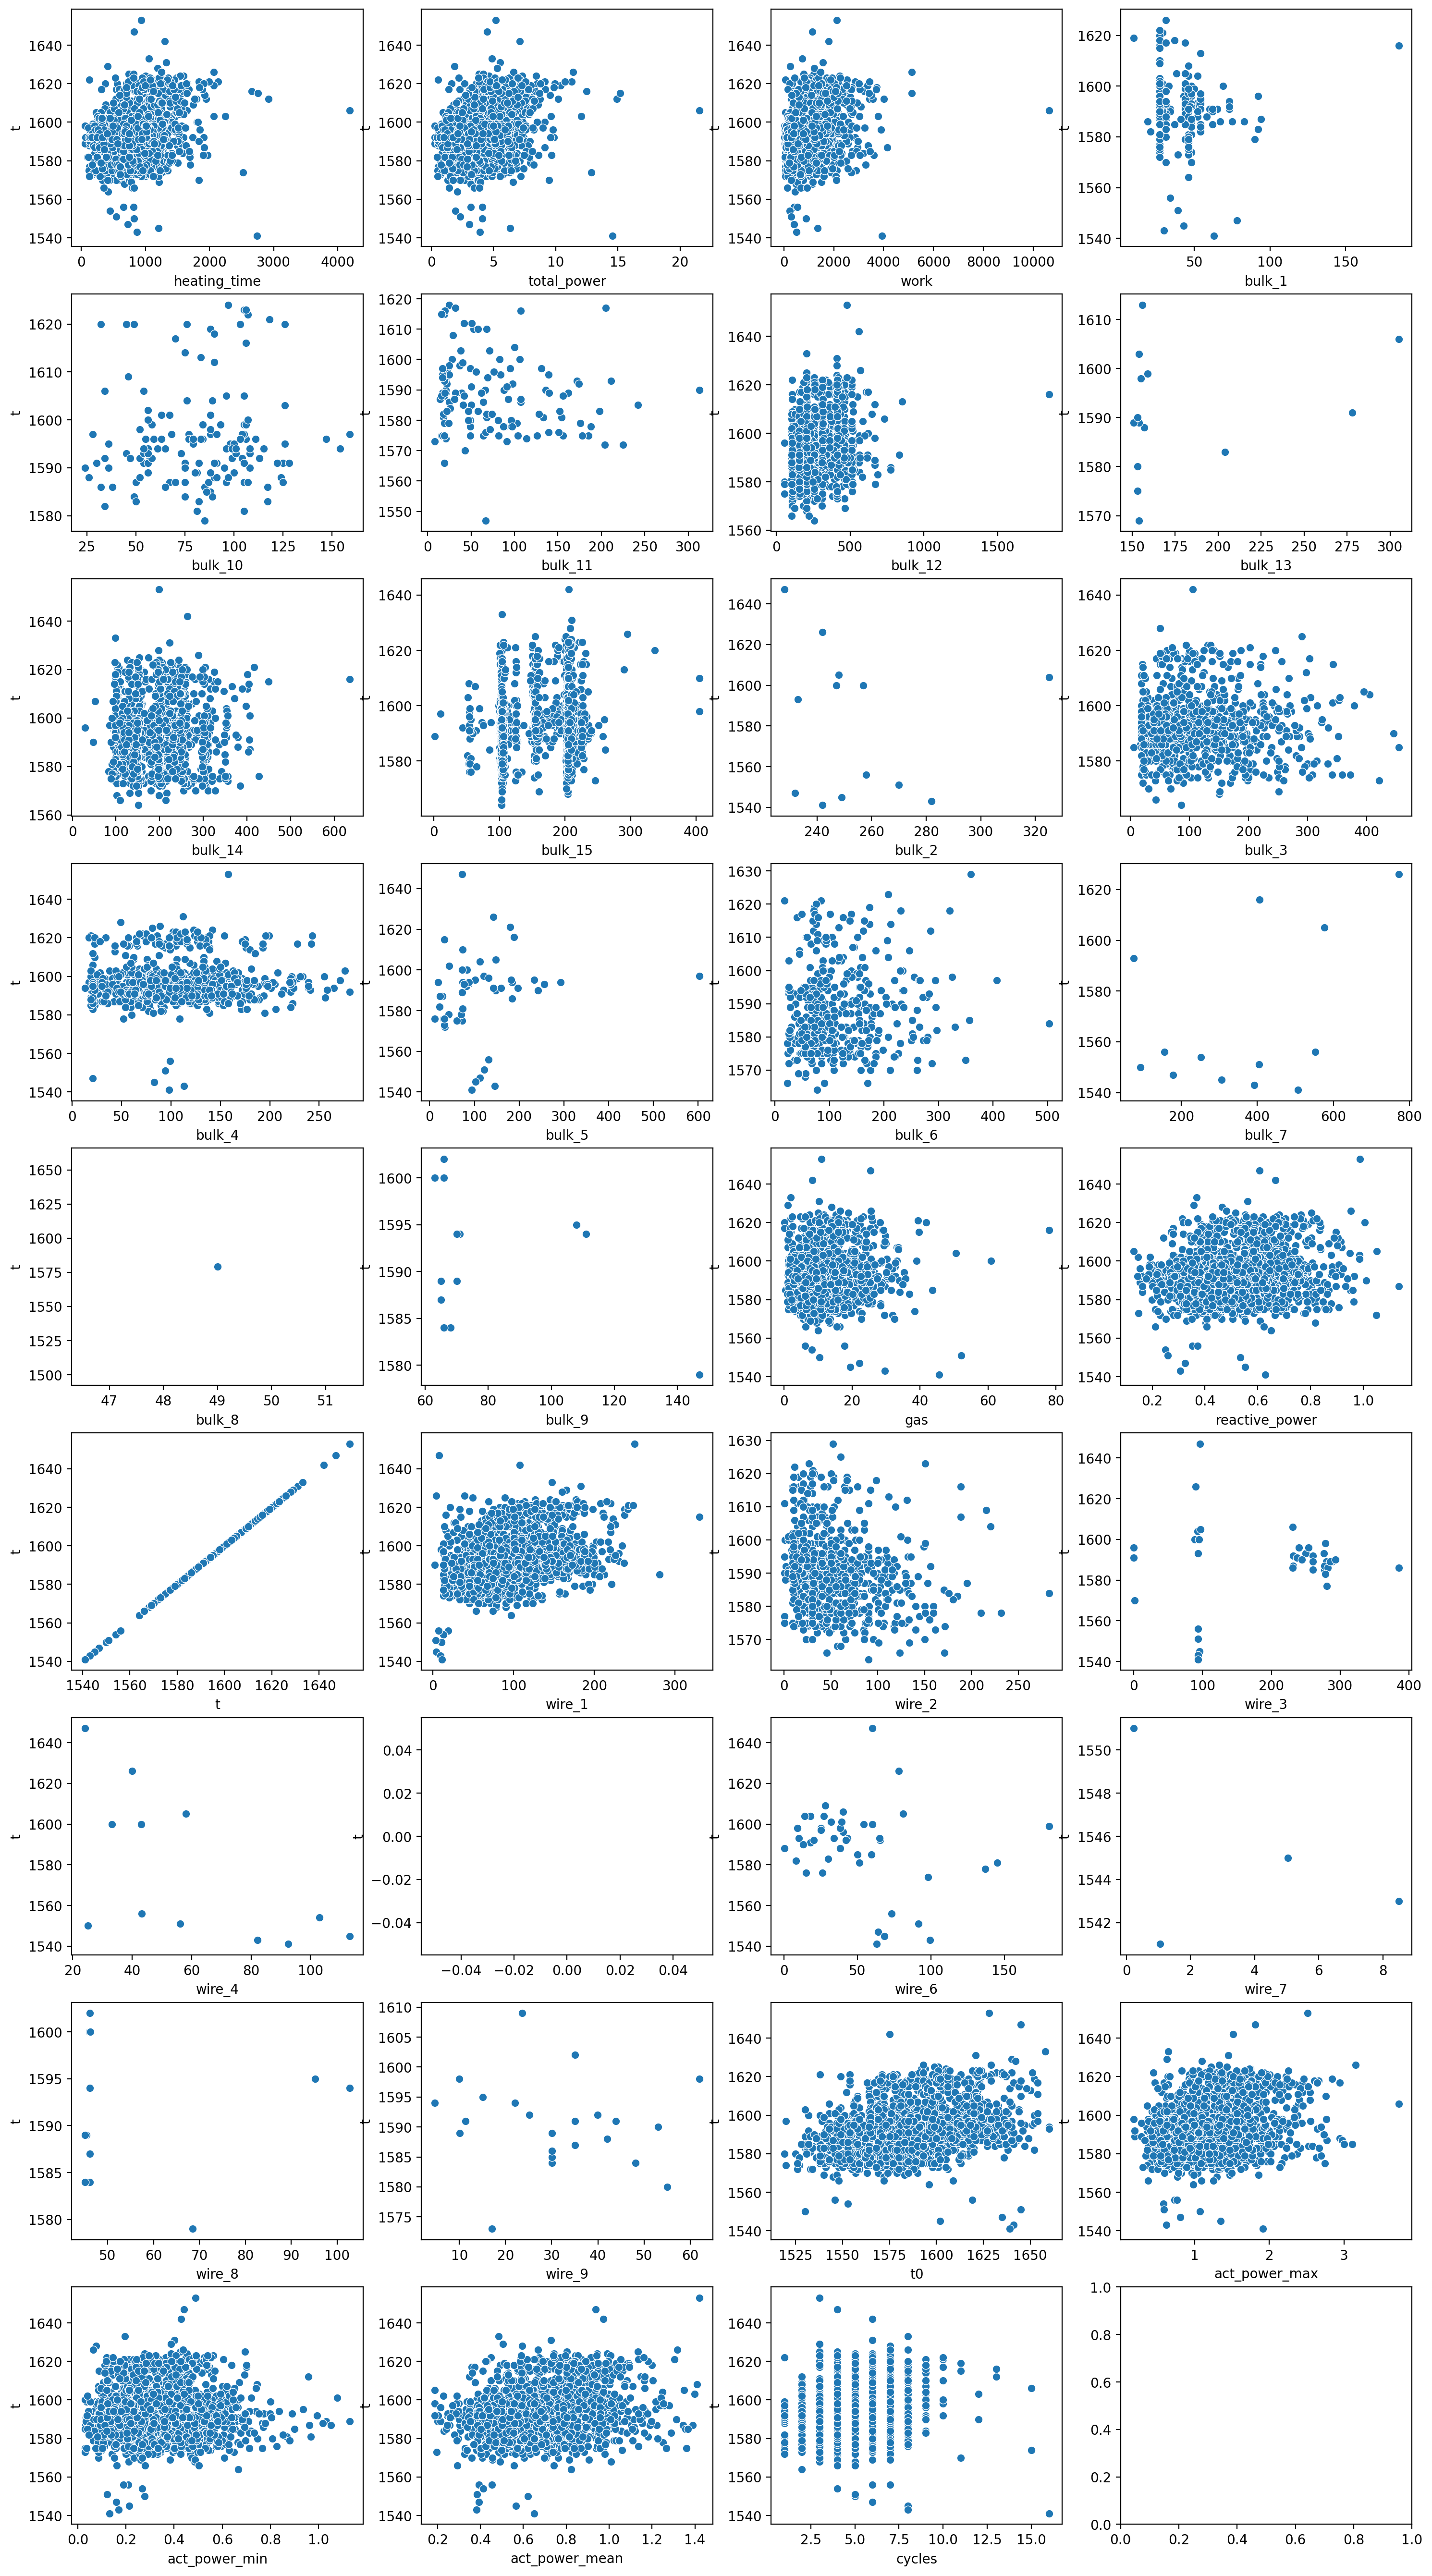

In [71]:
fig, axes = plt.subplots(9, 4, figsize=(18, 34))
for (col, ax) in zip(tmp.columns, axes.flatten()):
    sns.scatterplot(ax=ax, data=tmp, x=col, y='t')
    

Я вижу, что `wire_5` полностью пустой, а `bulk_8` имеет всего одно измерение - удалим эти величины из признаков. Еще все-таки немного смущают малочисленные признаки, такие как `wire_7`,  `bulk_2`. Пока я думаю, что не буду их удалять, мне кажется, что при построении моделей можно будет оценить их важность и откинуть их, если они будут не нужны.

In [72]:
df_final = df_final.drop(['key', 'wire_5', 'bulk_8'], axis=1)

Ключ удалили, так как он уже не нужен, мы собрали итоговую таблицу

Оценим еще численно коррелированность признаков

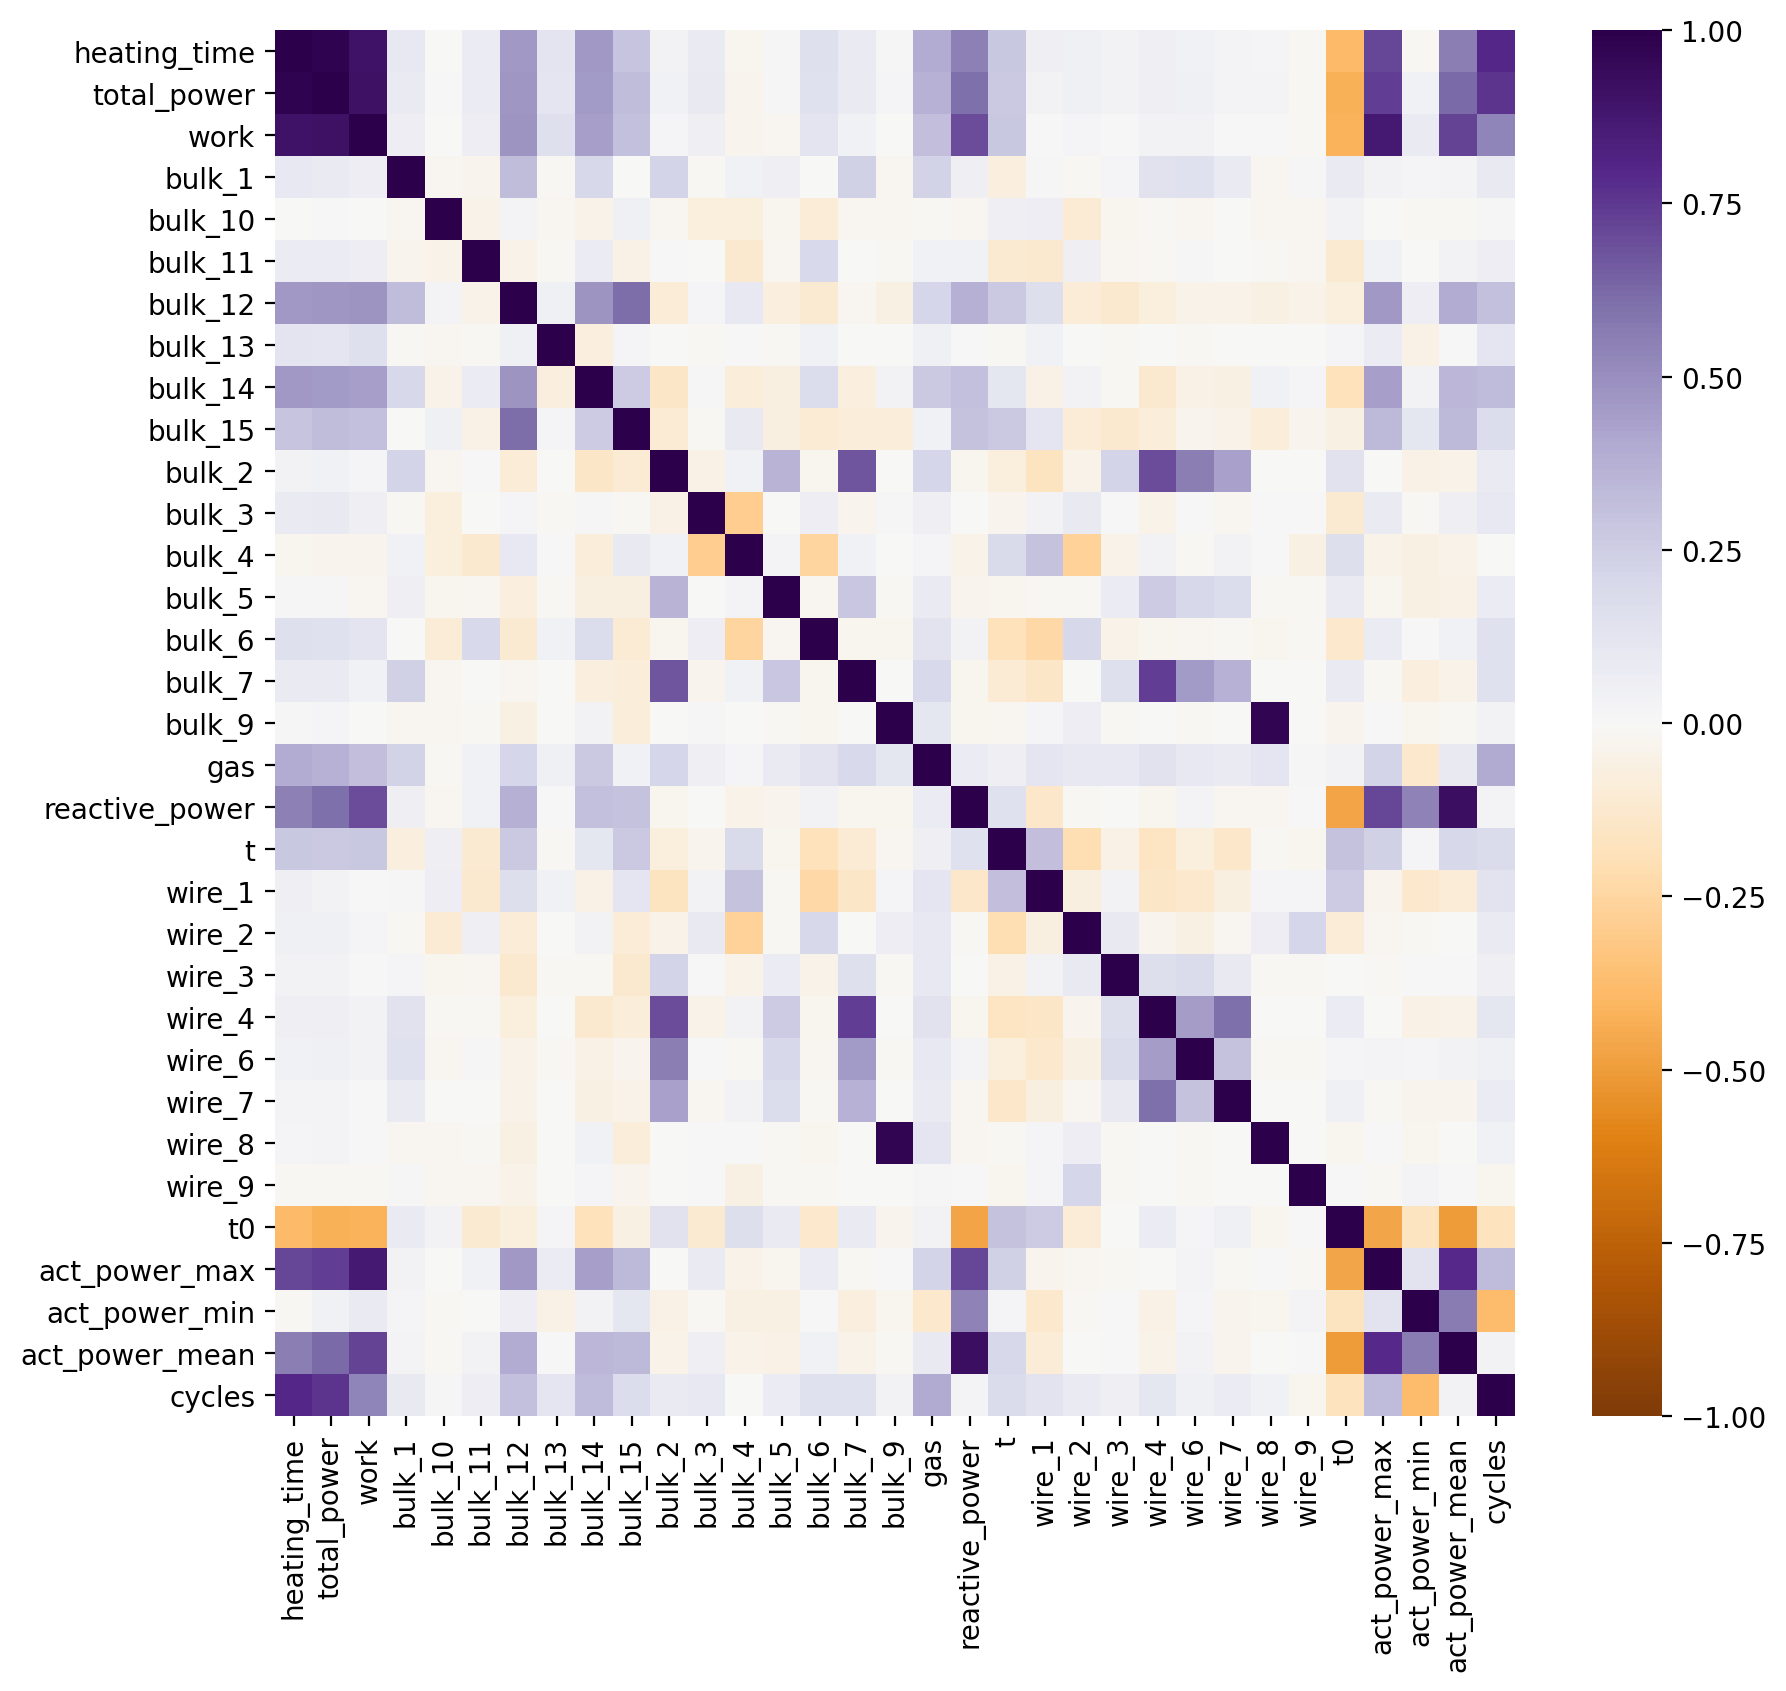

In [73]:
fig, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(df_final.corr(), 
            cmap=plt.cm.PuOr,
            vmin=-1, vmax=1
);

Вообще я ожидал, что `work` должно быть около единицы с `total_power` и `heating_time`, но оказалось, что последние два коррелируют между собой сильнее, хотя я прямой формулы между ними не знаю. Есть и другие скоррелированные признаки.
Итак, можно удалить из признаков:
* `total_power` - наверное лучше этот, чем `heating_time`, потому что последнее проще измерять
* `reactive_power` - вроде эта мощность не производит полезной работы, так что ее все-таки можно и убрать
* `wire_8` - особо без разницы этот или `bulk_9`

In [74]:
df_final = df_final.drop(['total_power', 'reactive_power', 'wire_8'], axis=1)

In [75]:
df_final.describe()

,heating_time,work,bulk_1,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_2,...,wire_3,wire_4,wire_6,wire_7,wire_9,t0,act_power_max,act_power_min,act_power_mean,cycles
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,...,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,808.196644,903.888406,3.435026,5.063683,4.254303,208.597676,1.069707,153.952668,120.078313,1.425559,...,3.241876,0.307209,0.980926,0.006374,0.317795,1587.368761,1.133344,0.339264,0.669399,4.696644
std,340.813828,651.027171,12.424463,20.938984,22.538843,157.112117,14.250280,81.410544,84.655967,19.102530,...,27.972523,4.762842,8.702531,0.205926,3.460248,23.627590,0.451769,0.148029,0.196982,1.606210
min,57.000000,15.158096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1519.000000,0.186226,0.030002,0.186226,1.000000
25%,581.000000,465.282483,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1571.000000,0.808763,0.236531,0.526662,4.000000
50%,778.000000,767.950715,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1587.000000,1.075292,0.320371,0.645157,5.000000
75%,993.000000,1166.456748,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1603.000000,1.361162,0.433729,0.792148,6.000000
max,4189.000000,10630.980668,185.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,325.000000,...,385.008668,113.231044,180.454575,8.490040,62.025600,1660.000000,3.731596,1.129269,1.421416,16.000000


## Вывод по исследовательской части
В результате первичного анализа были устранены аномалии в данных и скомпонована итоговая таблица, которая будет использована для построения моделей машинного обучения. В таблицу были добавлены некоторые физические признаки - работа, затраченная на нагрев, общее время нагрева. На данный момент было удержано максимальное число признаков, удалялся только один из попарно скоррелированных признаков и совсем редко встречающиеся признаки. Остальные неинформативные признаки будут отсеяны при обучении моделей.

# Подбор модели

Фиксируем заданные параметры

In [76]:
SEED = 110423
TEST_SIZE = 0.25

Делим данные на признаки и целевую переменную

In [77]:
features = df_final.drop(['t'], axis=1)
target = df_final['t']

Разбиваем на тренировочную и тестовую выборки

In [78]:
train_features, test_features, train_target, test_target = train_test_split(features, target, 
                                                                            random_state=SEED, 
                                                                            test_size=TEST_SIZE,
                                                                            shuffle=True
                                                                           )

Создадим функцию `search_best_model`. Идея в том, чтобы принимать модель для оптимизации гиперпараметров и сам вид оптимизации `GridSeacrhCV` или `BayesSearchCV`, обучать и выдавать модель

In [79]:
def search_best_model(model, reseacher, x, y, params, n_iter=None):
    '''
        model - модель для обучения
        reseacher - метод поиска гиперпараметров
        x - признаки
        y - целевая переменная 
        params - параметры поиска для reseacher
    '''
    np.random.seed(SEED)
    kw = {
        "n_jobs": -1, 
        "cv": 5,
        "scoring": make_scorer(mean_absolute_error, greater_is_better=False)
    }
    if n_iter is not None: 
        kw["n_iter"] = n_iter
    grid = reseacher(model, params, **kw)
    grid.fit(x, y)
    return grid
    

Создадим еще таблицу, чтобы сохранять результаты наших моделей

In [80]:
scores = pd.DataFrame(columns=['name', 'score'])

## Преобразование признаков

Для линейной модели можно попробовать от масштабировать признаки, но нужно не испортить категориальный признак `cycles`

In [81]:
num_features = features.columns[:-1]
cat_features = ['cycles']

In [82]:
transform_pipe = ColumnTransformer(
    transformers=[
        ('numerical', MinMaxScaler(), num_features)
#         ('categorial', OneHotEncoder(), cat_features)
    ],
    remainder='passthrough'
)

## ElasticNet Model 

Эта модель сочетает в себе Лассо и Ридж регуляризацию, мы будем подбирать оптимальное соотношение между ними.

Модель выглядит так

$1 / (2 \cdot n_{samples}) \cdot ||y - Xw||^2_2
+ \alpha \cdot l1_{ratio} \cdot ||w||_1
+ 0.5 \cdot \alpha \cdot (1 - l1_{ratio}) \cdot ||w||^2_2$

### С преобразованием признаков

Здесь мы сделаем приведение признаков к одному масштабу, кроме единственного категориального признака `cycles`

In [83]:
lin_model = Pipeline(
    steps=[
        ('feature_transform', transform_pipe),
        ('elastic_net', ElasticNet(random_state=SEED))
    ]
)

In [84]:
lin_model_params = {
    'elastic_net__alpha': Real(0.001, 1.0),
    'elastic_net__l1_ratio': Real(0.001, 1.0)
}

In [85]:
%%time
best_lin_model = search_best_model(
    model=lin_model, 
    reseacher=BayesSearchCV,
    x=train_features, 
    y=train_target,
    params=lin_model_params,
    n_iter=20
)

CPU times: total: 23.6 s
Wall time: 39.4 s


In [86]:
print(f"Best Model Score: {-best_lin_model.best_score_:.2f}")

Best Model Score: 6.32


В целом результат уже почти на 4 по данной нам шкале. Дальше попробуем его улучшить

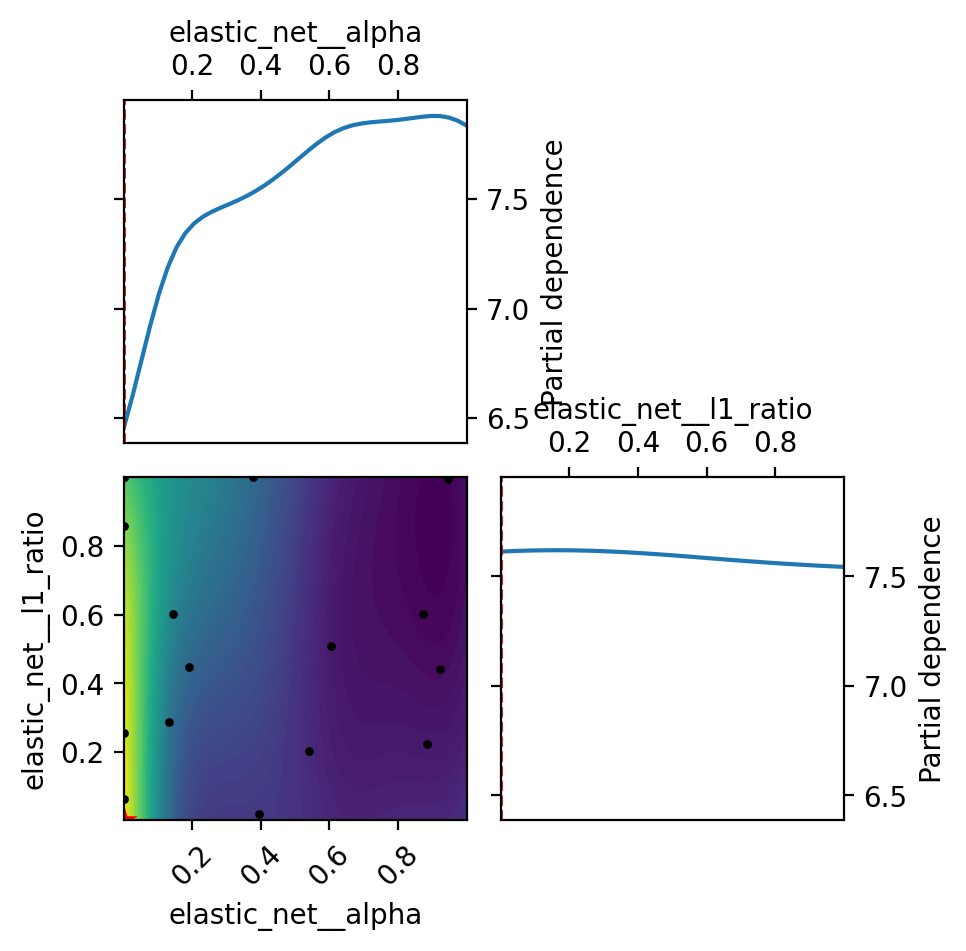

In [87]:
plot_objective(best_lin_model.optimizer_results_[0], levels=100);

In [88]:
best_lin_model.best_params_

OrderedDict([('elastic_net__alpha', 0.001), ('elastic_net__l1_ratio', 0.001)])

Вышло довольно интересно. После масштабирования алгоритм мне, можно сказать, занулил регуляризацию. Посмотрим еще на веса при признаках

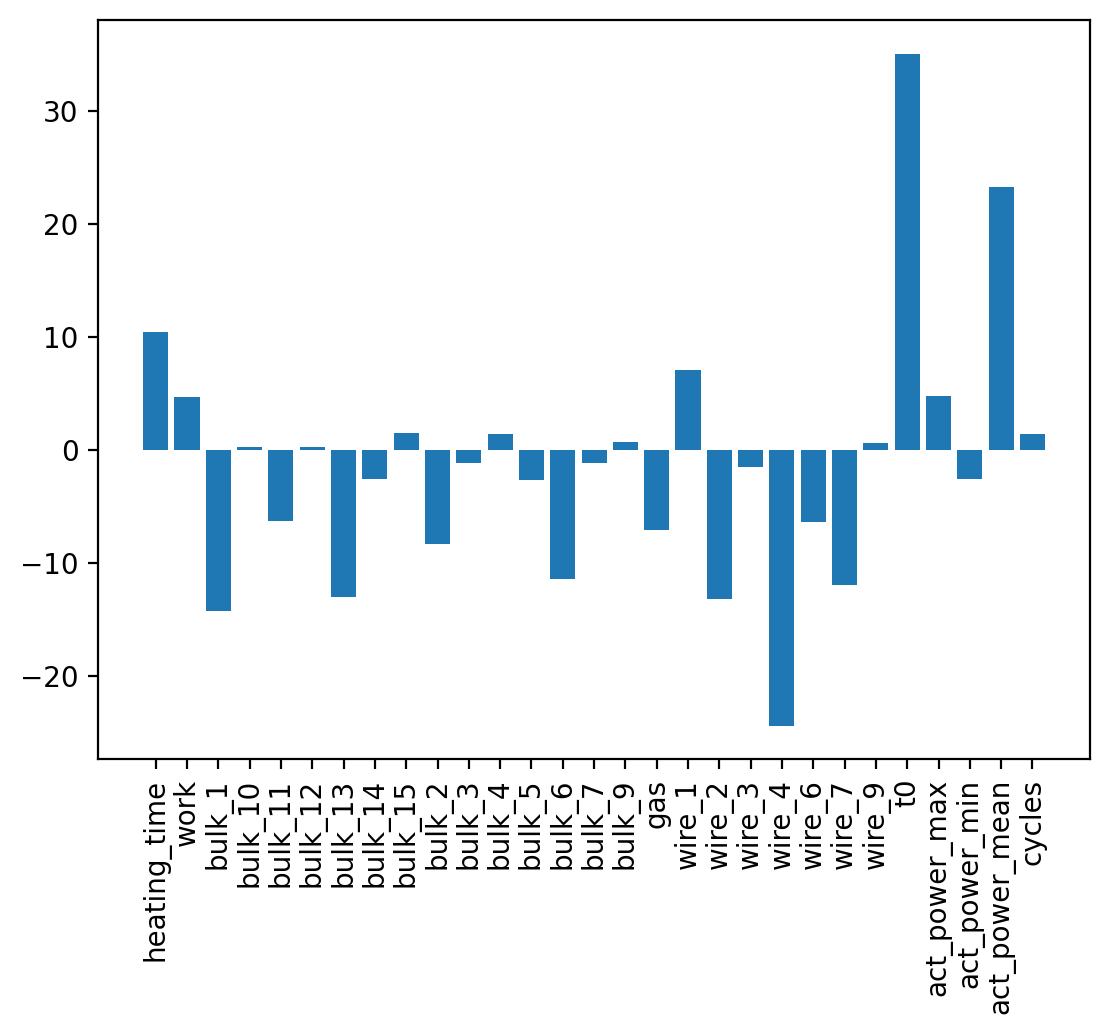

In [89]:
plt.bar(train_features.columns, best_lin_model.best_estimator_.get_params()['steps'][1][1].coef_)
plt.xticks(rotation=90);

Вот `t0` почему то ожидаемо было, а вот то, что отдельный вид примеси выделится - совсем нет

Сохраним результат в табличку

In [90]:
scores.loc[0] = ['lin_model_scale', -best_lin_model.best_score_]

In [91]:
scores

,name,score
0,lin_model_scale,6.321992


### Без масштабирования

Попробуем теперь сделать тоже самое, но без масштабирования признаковЭ

In [92]:
lin_model_params = {
    'alpha': Real(0.001, 1.0),
    'l1_ratio': Real(0.001, 1.0)
}

In [93]:
%%time
best_lin_model = search_best_model(
    model=ElasticNet(random_state=SEED), 
    reseacher=BayesSearchCV,
    x=train_features, 
    y=train_target,
    params=lin_model_params,
    n_iter=20
)

CPU times: total: 22.8 s
Wall time: 23.9 s


In [94]:
print(f"Best Model Score: {-best_lin_model.best_score_:.2f}")

Best Model Score: 6.19


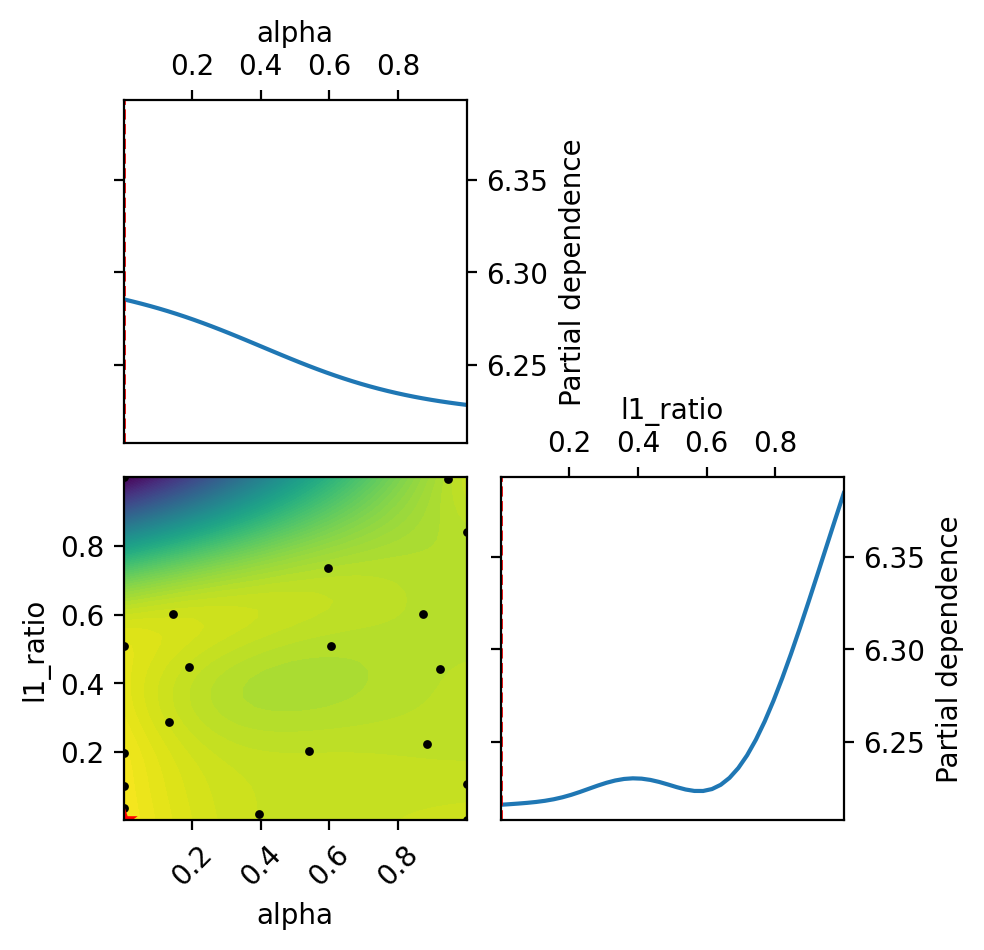

In [95]:
plot_objective(best_lin_model.optimizer_results_[0], levels=100);

In [96]:
best_lin_model.best_params_

OrderedDict([('alpha', 0.001), ('l1_ratio', 0.001)])

Здесь алгоритм тоже свел на нет регуляризацию, но чуть лучше построился под данные

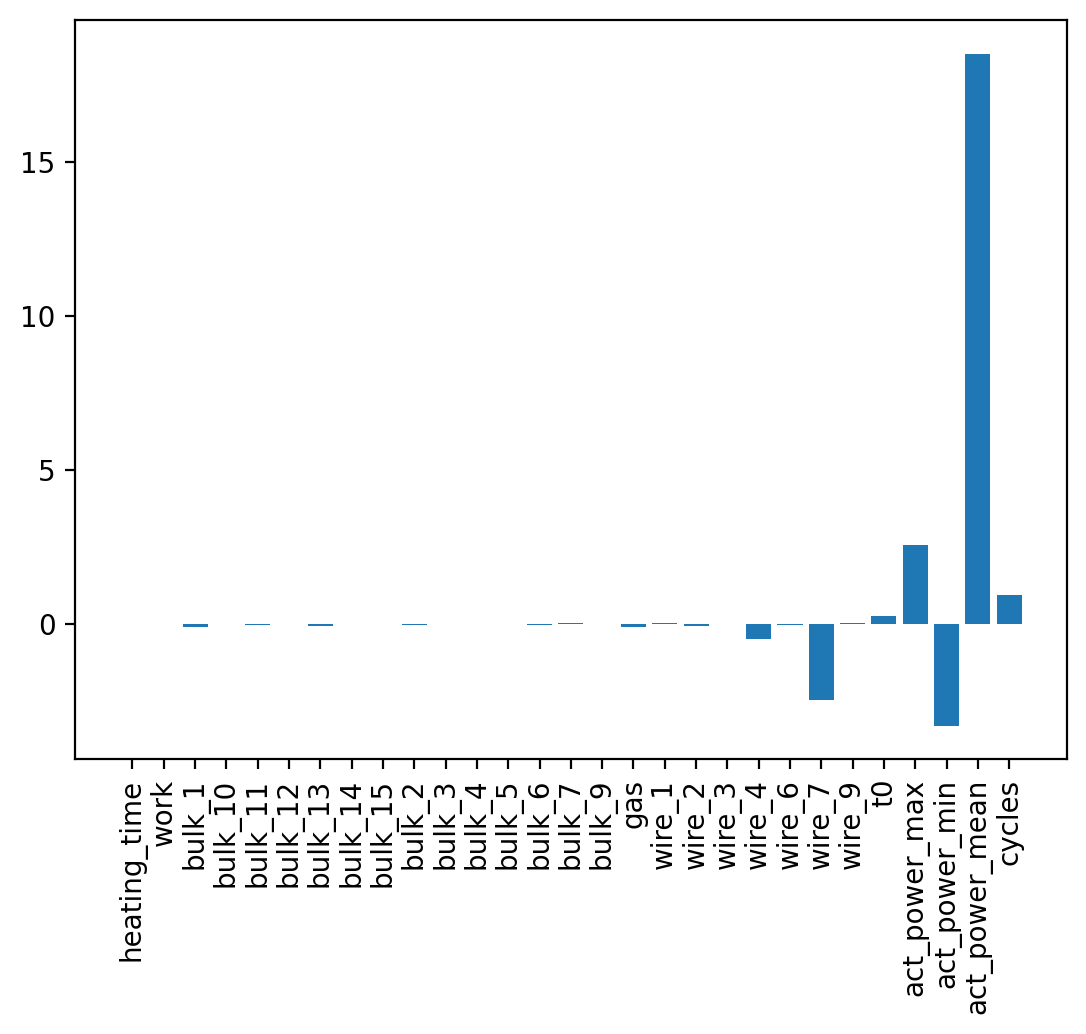

In [97]:
plt.bar(train_features.columns, best_lin_model.best_estimator_.coef_)
plt.xticks(rotation=90);

При этом модель больше полагалась на величины затраченных мощностей, нежели на начальную температуру

In [98]:
scores.loc[1] = ['lin_model_no_scale', -best_lin_model.best_score_]

In [99]:
scores

,name,score
0,lin_model_scale,6.321992
1,lin_model_no_scale,6.189018


## Random Forest

Теперь посмотрим на ансамблевую модель. Здесь уже будем использовать `GridsearchCV` для поиска гиперпараметров

In [100]:
rf_param_grid={
        'n_estimators': [100, 128, 200],
        'max_depth': [4, 8, 12, 16, 20, 24],
        'max_features': ['log', 'sqrt']
}

In [101]:
%%time
best_rf_model = search_best_model(
    model=RandomForestRegressor(random_state=SEED), 
    reseacher=GridSearchCV,
    x=train_features, 
    y=train_target,
    params=rf_param_grid
)

CPU times: total: 3.12 s
Wall time: 16.6 s


In [102]:
best_rf_model.best_estimator_

RandomForestRegressor(max_depth=24, max_features='sqrt', n_estimators=200,
                      random_state=110423)

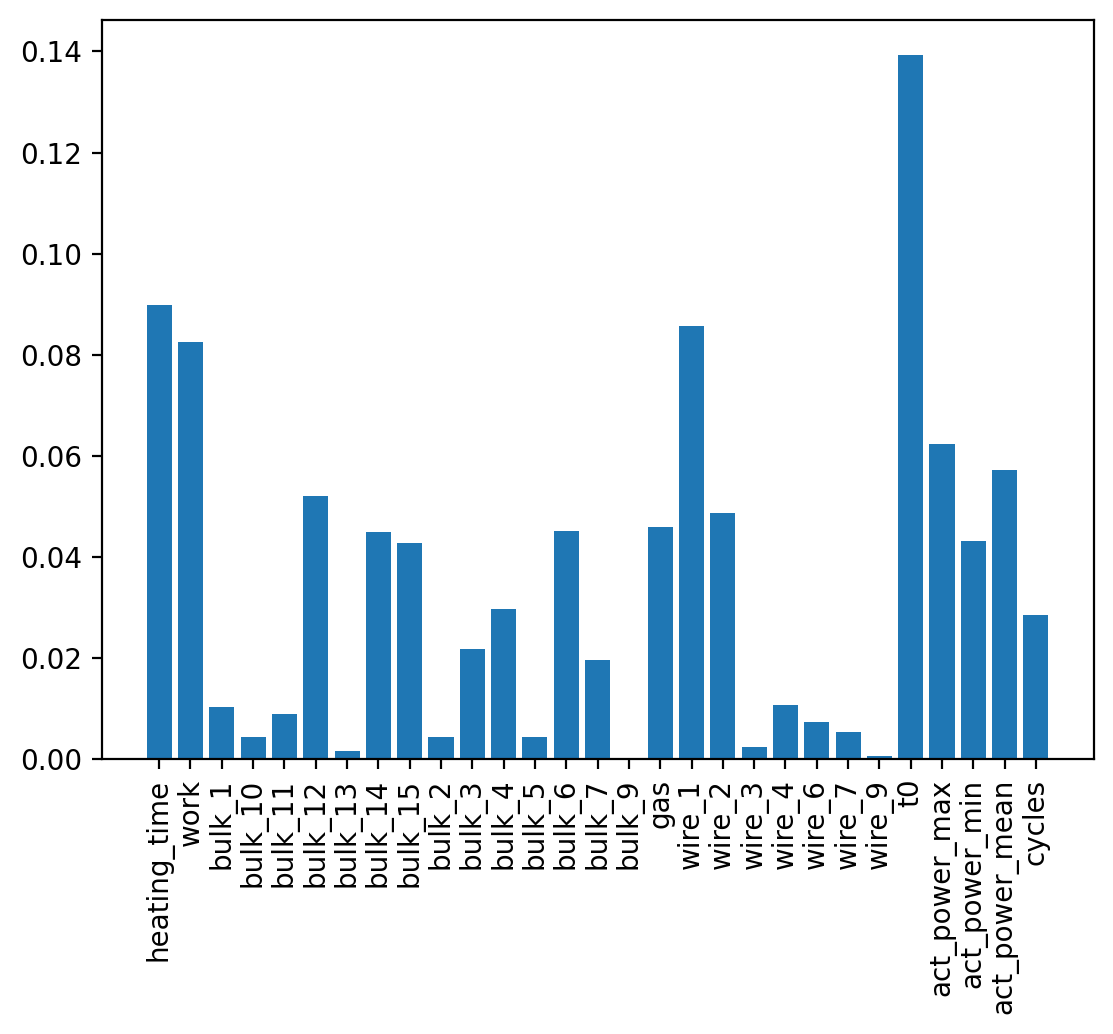

In [103]:
plt.bar(train_features.columns, best_rf_model.best_estimator_.feature_importances_)
plt.xticks(rotation=90);

In [104]:
print(f"Best Model Score: {-best_rf_model.best_score_:.2f}")

Best Model Score: 6.33


In [105]:
scores.loc[2] = ['rf_model', -best_rf_model.best_score_]

In [106]:
scores

,name,score
0,lin_model_scale,6.321992
1,lin_model_no_scale,6.189018
2,rf_model,6.329791


Вышло не очень здорово, линейная регрессия пока справляется лучше

## LightGBM

Первый из методов градиентного бустинга, который мы попробуем применить. Я выставил минимизации по метрике MSE, так как по ней считалось значительно быстрее. Финальный результат оценивался уже по МАЕ

In [107]:
lgbm_model = lgb.LGBMRegressor(
    random_state=SEED, 
    metric='mse'
)

lgbm_pipe = Pipeline(
    steps=[
#         ('feature_transform', transform_pipe),
        ('lgbm_boosting', lgbm_model)
    ]
)

In [108]:
lgbm_param_grid={
    'lgbm_boosting__learning_rate': [1e-04, 1e-03, 1e-2, 0.1],
    'lgbm_boosting__n_estimators': [400, 500, 600]
}

In [109]:
%%time
lgbm_best_model = search_best_model(
    model=lgbm_pipe, 
    reseacher=GridSearchCV,
    x=train_features, 
    y=train_target,
    params=lgbm_param_grid
)

CPU times: total: 4.09 s
Wall time: 11.1 s


In [110]:
lgbm_best_model.best_estimator_

Pipeline(steps=[('lgbm_boosting',
                 LGBMRegressor(learning_rate=0.01, metric='mse',
                               n_estimators=500, random_state=110423))])

In [111]:
predict = lgbm_best_model.predict(train_features)

In [112]:
print(f"Best Model Score: {mean_absolute_error(predict, train_target):.2f}")

Best Model Score: 3.67


In [113]:
scores.loc[3] = ['lgbm_model', mean_absolute_error(predict, train_target)]

In [114]:
scores

,name,score
0,lin_model_scale,6.321992
1,lin_model_no_scale,6.189018
2,rf_model,6.329791
3,lgbm_model,3.672377


У нас есть новый лидер) Масштабирование признаков здесь снова показало результат по хуже, поэтому его просто закомментировал

## CatBoost

Теперь попробуем алгоритм от Яндекса

Сначала без надстроек

In [115]:
ya_model = CatBoostRegressor(
    random_seed=SEED, loss_function='RMSE',
    cat_features=['cycles'], 
    task_type='CPU', 
    verbose=0
)

In [116]:
%%time
ya_model.fit(train_features, train_target)

CPU times: total: 1min 51s
Wall time: 1min 12s


Оцениваем алгоритм по МАЕ

In [117]:
predict = ya_model.predict(train_features)
mean_absolute_error(predict, train_target)

2.933084164823542

In [118]:
scores.loc[4] = ['ya_model_from_box', mean_absolute_error(predict, train_target)]

Теперь по подбираем гиперпараметры

In [119]:
ya_model_grid = CatBoostRegressor(
    random_seed=SEED, loss_function='RMSE',
    cat_features=['cycles'], 
    task_type='CPU', 
    verbose=0
)
ya_params = {
    'n_estimators': [800, 900, 1000, 1200]
}

In [120]:
ya_grid = ya_model_grid.grid_search(ya_params, X=train_features, y=train_target)


bestTest = 28.1286505
bestIteration = 799

0:	loss: 28.1286505	best: 28.1286505 (0)	total: 58s	remaining: 2m 54s

bestTest = 27.8734944
bestIteration = 899

1:	loss: 27.8734944	best: 27.8734944 (1)	total: 2m 4s	remaining: 2m 4s

bestTest = 27.70767565
bestIteration = 998

2:	loss: 27.7076757	best: 27.7076757 (2)	total: 3m 24s	remaining: 1m 8s

bestTest = 27.48696081
bestIteration = 1196

3:	loss: 27.4869608	best: 27.4869608 (3)	total: 5m 2s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 27.1113669
bestIteration = 1195

Training on fold [1/3]

bestTest = 20.49735167
bestIteration = 1199

Training on fold [2/3]

bestTest = 25.57577047
bestIteration = 1199



In [121]:
predict = ya_model_grid.predict(train_features)
mean_absolute_error(predict, train_target)

2.9197721322042565

In [122]:
scores.loc[5] = ['ya_model_tune', mean_absolute_error(predict, train_target)]

## Сравнение моделей

Теперь нужно сравнить модели и выбрать лучшую. Также добавим константную модель, как репертную точку

In [123]:
constant_model_score = mean_absolute_error(np.ones(test_target.shape[0])*test_target.mean(), test_target)

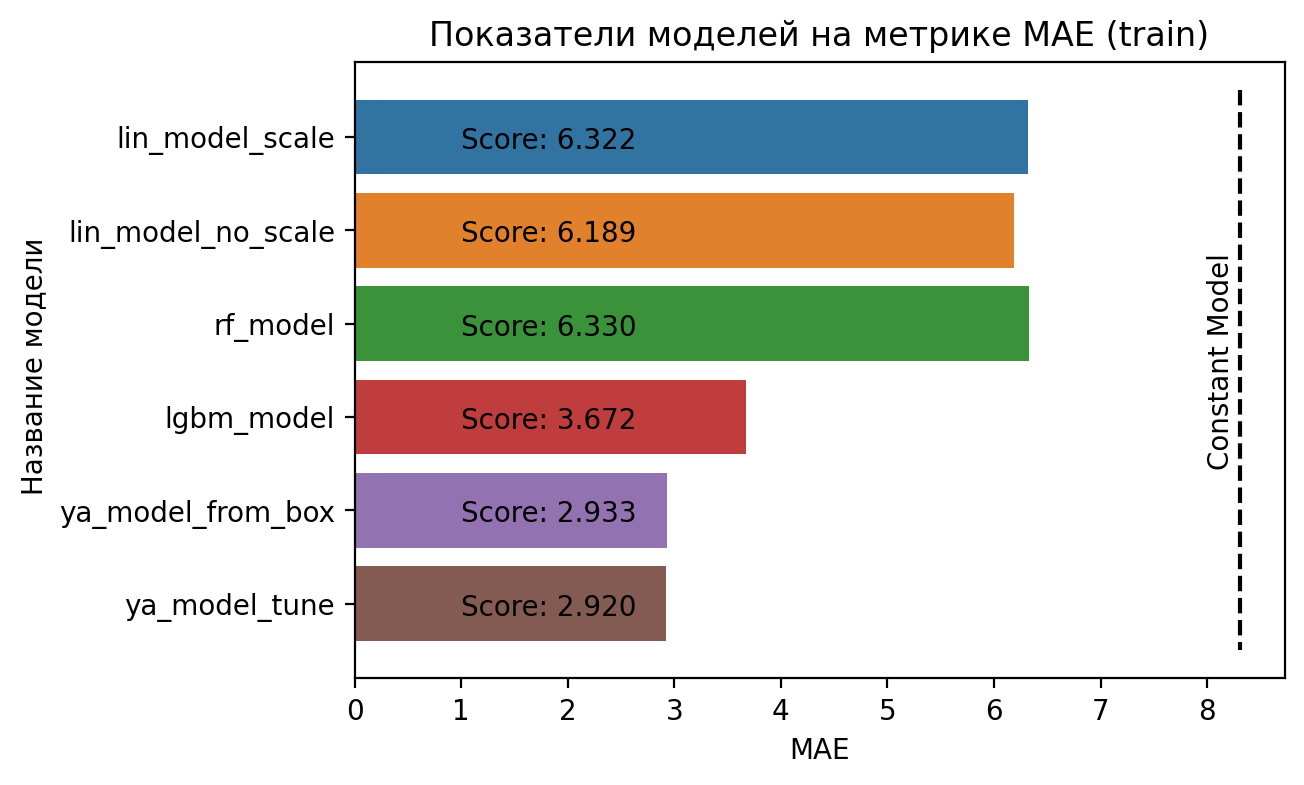

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(data=scores, y='name', x='score')
for i in range(6):
    ax.annotate(f"Score: {scores.loc[i, 'score']:.3f}", (1, i+0.125) )
ax.vlines(constant_model_score, -0.5, 5.5, color='black', ls='--')
ax.annotate('Constant Model', xy=(8, 3.5), rotation=90)

ax.set(
    title='Показатели моделей на метрике МАЕ (train)',
    xlabel='MAE',
    ylabel=' Название модели'
);

Получается что лучшей стала модель градиентного бустинга `catboost` с измененными параметрами

# Тестирование лучшей модели

In [125]:
predict = ya_model_grid.predict(test_features)
mean_absolute_error(predict, test_target)

5.9111673961925675

Итоговый результат вышел довольно неплохим

В добавление посмотрим какие признаки были наиболее ценными для нашей модели

In [126]:
features_importance = pd.DataFrame(
    data=ya_model_grid.feature_importances_,
    index=ya_model_grid.feature_names_,
    columns=['value']
)

In [127]:
features_importance = features_importance.sort_values(by='value')

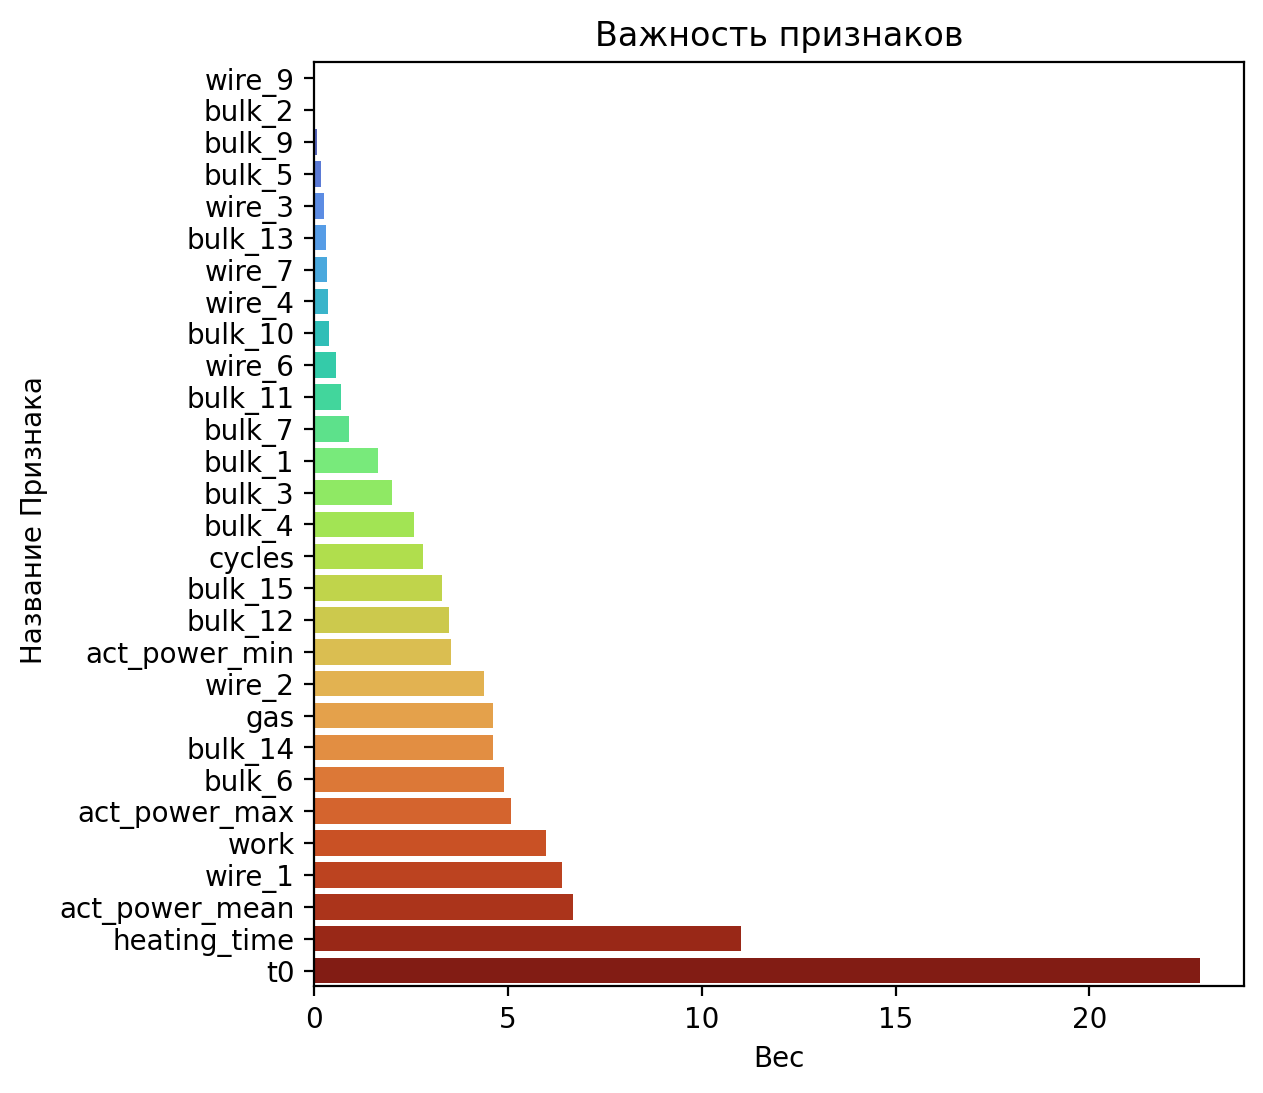

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.barplot(
    y=features_importance.index, 
    x=features_importance['value'] ,
    palette='turbo'
)
ax.set(
    title='Важность признаков',
    xlabel='Вес',
    ylabel=' Название Признака'
);

Получается наиболее важными для модели оказались:
* Начальная температура 
* Время нагрева
* Средняя активная мощность

Самым же важным является начальная температура, что для меня странно, так как я не могу это физически связать, потому что, если я смотрю на конечную температуру, то мне без разницы откуда стартовать. Мне так или иначе придется нагреть сплав до необходимой температуры плавления либо металла, либо добавляемой примеси.

# Вывод

В данном проекте мы по заказу металлургического комбината ООО «Так закаляем сталь» построили модель машинного обучения для оптимизирования технологического процесса. 

Компания предоставила накопленные сырые данные, которые были очищены от аномальных значений и выбросов и проанализированы. На основе анализа была подготовлена итоговая таблица признаков, которая использовалась для обучения моделей. 

В качестве кандидатов рассматривались линейные модели `ElasticNet`, ансамблевые `RandomFForest` и модели градиентного бустинга `LightGBM` и `CatBoost`. В результате обучения лучшей по метрике МАЕ на кросс-валидации (5 дроблений) оказалась модель градиентного бустинга `CatBoost`, которая способна предсказывать температуру сплава с точностью до 5.9 градуса. 

Таким образом нами была построена модель, способная довольно точно восроизводить процесс создания различных сплавов, что поможет комбинату не только сэкономить на электроэнергии и материалах, но и позволит проводить эксперименты для новых видов сплавов.

# Отчет по проекту - Промышленность 
___
## Введение в проблему
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

___
## Цель проекта 
Построить модель машинного обучения, которая сможет искусственно воспроизводить процесс создания сплава, определяя его конечную температуру. Таким образом можно будет проводить численные эксперименты по оптимизации технологического процесса, - (сокращение или увеличения цикла циклов до достижения сплавом определенной консистенции, оптимизация времени нагрева) - что позволит сократить расходы материалов и электроэнергии.
___
## Процесс выполнения 
### Подготовка данных
Компания предоставила сырые данные в ходе производства предыдущих сплавов в виде нескольких таблиц. 

#### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

#### Очистка 
По информации заказчика сырые данные могли содержать две аномалии: это сильно отрицательная мощность и температуры менее 1500 градусов.Оба этих случая были устранены. На основе анализа была подготовлена итоговая таблица признаков, которая использовалась для обучения моделей. 
Также были исключены данные с отсутствующей финальной температурой сплава

#### Создание новых признаков
Для улучшения показателей моделей машинного обучения были сгенерированы несколько дополнительных признаков на основе обработанных данных:
* Общее время изготовления сплава
* Активная мощность
    * Средняя мощность в процессе создания
    * Минимальная мощность
    * Максимальная мощность
* Работа (энергия) затраченная на изготовление
* Число циклов изготовления 


### Построение моделей 
#### Установки
Подготовленные данные были разделены на тренировочную и тестовую выборки в соотношении 4:1. Также для воспроизводимости результатов был зафиксирован генератор пседвослучайных чисел. 

Всего было исследовано три класса моделей машинного обучения:
* Линейные модели с регуляризацией 
    * Без масштабирования признаков
    * С масштабированием признаков
* Ансамблевая модель случайного леса
* Модели градиентного бустинга (LightGBM, CatBoost)

Качество моделей измерялось по метрике МАЕ: $L = \sum_i^N\frac{|y_i - y_i^0|}{N}$, где $L$ - финальное значение ошибки, N - число измерений, $y_0^i, y_i$ - истинные и предсказанные значения финальной температуры. Наилучшая модель отбиралась по лучшему значению на кросс-валидации. 

#### Результаты обучения 
Для удобства оценки и выборка наилучшей модели была заполнена таблица с показателями лучших алгоритмов из каждой категории.


<table border="1" width="100%">
 <tr>
    <td width="40%"> <table border="1" width="100%">
 <tr>
    <td>Название модели  </td> <td>Название на рисунке </td> <td>МАЕ</td>
 </tr>
 <tr>
    <td>Линейная модель с масштабированием</td> <td>lin_model_scale</td> <td>6.321992</td>
 </tr>
 <tr>
    <td>Линейная модель без масштабирования</td> <td>lin_model_no_scale</td> <td>6.189018</td>
 </tr>
 <tr>
    <td>Случайный лес</td> <td>rf_model</td> <td>6.329791</td>
 </tr>
 <tr>
    <td>LGBM </td> <td>lgbm_model</td> <td>3.672377</td>
 </tr>
 <tr>
    <td>CatBoost без надстроек</td> <td>ya_model_from_box</td> <td>2.933084</td>
 </tr>
 <tr>
    <td>CatBoost с подбором параметров</td> <td>ya_model_tune</td> <td>2.919772</td>
 </tr>
 </table></td>
     <td width="40%"> <img src=https://s1.hostingkartinok.com/uploads/images/2023/04/eec87309fe28e6c455a5945c010fdd03.png align="right"></td>
 </tr>
</table>

По представленным данным можно увидеть, что алгоритм градиентного бустинга CatBoost после небольшой надстройки дает наилучший показатель на тренировочной выборке. 
<img src=https://s1.hostingkartinok.com/uploads/images/2023/04/a2feeb11ff93459e1f49d4af6819a3bb.png width=40%>
При этом данный алгоритм выделяет начальную температуру, время нагрева и средняя активная мощность наиболее важными признаками. Последние два можно попробовать связать с тем, что чем дольше или сильнее нагреваешь сплав, тем выше конечная температура.

## Заключение
___
На основании проведенного анализа и моделирования мы можем предложить модель машинного обучения способную предсказать конечную температуру сплава с точностью до 5.9 градусов. Данная модель может использоваться для численного подбора параметров производства при минимизации расходов по электроэнергии.

# Ответы на вопросы

__1. Какие пункты плана были выполнены, а какие — нет. Почему?__

Вроде все получилось. Единственное, мне не хватило времени на более обширные эксперименты с моделями.

__2. Какие трудности возникли и как вы их преодолели?__

Создание новых физических признаков - некоторые возникали совершенно естественно, а за некоторыми пришлось залезть в учебники

__3. Какие ключевые шаги в решении задачи вы выделили?__

* Построение плана
* Обработка и исследование данных 
* Построение pipelin'ов для моделей
* Формулировка вывода по полученным результатам

__4. Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?__

Я старался использовать все признаки, предоставленные заказчиком, плюс новые, которые мне удалось придумать. Из исходных признаков были удалены обозначенные заказчиком аномалии.

__5. Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?__

Лучшей стала модель градиентного бустинга `CatBoost`, настраивались следующие гиперпараметры:
* learning_rate = 0.038 (он подбирается автоматически)
* n_estimators = 1200 - максимальное число деревьев, которое может быть взято в ансамбле

Итоговая метрика МАЕ составила 5.9 градусов. 